In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### ✅손동작 분류 경진대회: EDA and Model fit

- 손에 부착된 센서의 데이터를 통해 총 4개의 종류의 손동작을 분류한다.
- 주어진 데이터 이외의 데이터는 사용이 금지된다.
- metric: accuracy score
- 딥러닝 모델로 접근하는 방식이 좋은 결과를 도출해 낼 수 있지만 머신러닝 모델로 접근할 예정. EDA도 그런 관점에서 진행.

**라이브러리 불러오기**

In [2]:
from typing import MutableSequence
import platform

import pandas as pd
import numpy as np
pd.set_option("display.max_columns", 100)

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
plt.style.use('ggplot')
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

from scipy import stats

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA

if platform.system() == "Windows":
    plt.rcParams["font.family"] = "Malgun Gothic"
else:
    plt.rcParams["font.family"] = "AppleGothic"

import warnings
warnings.filterwarnings(action = "ignore")

import os

**데이터 불러오기**

In [3]:
file_path = '/content/drive/MyDrive/모각코/hand_gesture/data/'

In [4]:
train_df = pd.read_csv(file_path + 'train.csv')
test_df = pd.read_csv(file_path + 'test.csv')
sample_submission_df = pd.read_csv(file_path + 'sample_submission.csv')

In [5]:
print("Shape of train data:", train_df.shape)
display(train_df.head())

print("Shape of test data:", test_df.shape)
display(test_df.head())

print("Shape of sample submission data:", sample_submission_df.shape)
display(sample_submission_df.head())

Shape of train data: (2335, 34)


,id,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,target
0,1,-6.149463,-0.929714,9.058368,-7.017854,-2.958471,0.179233,-0.956591,-0.972401,5.956213,4.145636,25.017645,-4.061254,0.996632,-3.837345,-13.956994,-2.042957,2.130210,-1.957662,-1.149930,6.082028,0.878612,5.093102,-6.066648,-7.026436,-6.006282,-6.005836,7.043084,21.884650,-3.064152,-5.247552,-6.026107,-11.990822,1
1,2,-2.238836,-1.003511,5.098079,-10.880357,-0.804562,-2.992123,26.972724,-8.900861,-5.968298,-4.060134,2.952843,-5.046353,1.083819,3.978378,-25.072542,-2.041602,2.912269,-3.998035,6.069698,4.966187,1.994051,-1.132059,14.906205,-1.996714,-7.933806,-3.136773,8.774211,10.944759,9.858186,-0.969241,-3.935553,-15.892421,1
2,3,19.087934,-2.092514,0.946750,-21.831788,9.119235,17.853587,-21.069954,-15.933212,-9.016039,-5.975194,-23.218408,-9.000630,9.115957,12.097318,-10.954367,-3.930714,-19.069594,-6.118940,-5.001346,-9.105371,-9.894885,10.107614,4.948570,-6.889685,54.052330,-6.109238,12.154595,6.095989,-40.195088,-3.958124,-8.079537,-5.160090,0
3,4,-2.211629,-1.930904,21.888406,-3.067560,-0.240634,2.985056,-29.073369,0.200774,-1.043742,2.099845,-15.123774,-0.069867,-0.114247,-1.896109,5.127194,-2.877423,2.970044,-1.099702,3.116767,8.124209,-0.917418,-1.027199,14.048298,-2.126170,-1.035526,2.178769,10.032723,-1.010897,-3.912848,-2.980338,-12.983597,-3.001077,1
4,5,3.953852,2.964892,-36.044802,0.899838,26.930210,11.004409,-21.962423,-11.950189,-20.933785,-4.000506,16.010442,5.961219,9.907115,-0.067754,-9.970728,0.868499,1.892233,-3.161698,-9.225990,3.953956,-17.959652,-3.115491,-6.051674,-2.051761,10.917567,1.905335,-13.004707,17.169552,2.105194,3.967986,11.861657,-27.088846,2


Shape of test data: (9343, 33)


,id,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32
0,1,0.067135,5.040383,-2.965405,-12.952880,-1.938465,-10.997802,1.853669,21.077862,7.963131,0.009773,-8.048277,-23.975623,-2.938174,1.757796,3.982687,-18.094173,-0.055343,2.085911,1.885611,3.929806,7.987616,-1.047750,8.128448,5.871833,1.889536,-3.926719,0.929041,4.999071,-7.963270,4.044370,-1.993315,10.855771
1,2,6.890655,-12.010728,24.881907,38.943245,-4.757496,5.926453,7.923851,3.925545,4.012127,-6.921524,-3.046893,-11.052956,4.912758,16.986902,-11.192310,8.993925,-0.825023,3.969301,-19.889173,-17.971799,0.871808,-8.018209,-7.941582,-27.106928,-16.940167,-11.169073,0.202975,6.846631,7.911875,-2.852819,56.028042,52.967175
2,3,-4.809695,0.962863,-1.893647,-6.168084,-3.948282,0.977219,12.960620,-9.048958,5.969053,0.874370,-12.870060,12.018730,-1.972370,-4.989797,7.043337,-1.141632,6.174780,3.030673,-15.931609,9.983416,-3.251407,0.981729,-0.895094,-7.984137,-0.025761,2.981749,4.948704,-10.841968,-4.860024,-6.917495,2.842422,-3.081374
3,4,0.018158,-3.993114,12.001667,22.960746,-2.121793,-6.002385,2.173744,1.045248,1.073869,-0.019322,-26.977501,-8.132294,-1.062246,-3.028002,27.782447,3.024800,-4.103924,-4.145369,-7.963091,-7.131190,1.070134,1.999624,-10.084452,2.828070,0.903349,5.156367,40.827713,-1.160840,-1.215552,0.037914,-24.968873,-7.148603
4,5,-7.841592,-2.129997,7.872448,-8.953428,28.080007,-5.019895,-10.922551,-15.045833,-56.981894,-8.831718,-39.009595,26.919958,-8.052420,13.759281,-18.026002,1.073389,49.029965,-4.794785,37.975778,-1.941377,-21.816534,-7.096878,-2.000975,-23.942689,-6.741350,0.831967,11.905613,3.106004,46.899363,3.001353,-17.881074,-6.882390


Shape of sample submission data: (9343, 2)


,id,target
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 34 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         2335 non-null   int64  
 1   sensor_1   2335 non-null   float64
 2   sensor_2   2335 non-null   float64
 3   sensor_3   2335 non-null   float64
 4   sensor_4   2335 non-null   float64
 5   sensor_5   2335 non-null   float64
 6   sensor_6   2335 non-null   float64
 7   sensor_7   2335 non-null   float64
 8   sensor_8   2335 non-null   float64
 9   sensor_9   2335 non-null   float64
 10  sensor_10  2335 non-null   float64
 11  sensor_11  2335 non-null   float64
 12  sensor_12  2335 non-null   float64
 13  sensor_13  2335 non-null   float64
 14  sensor_14  2335 non-null   float64
 15  sensor_15  2335 non-null   float64
 16  sensor_16  2335 non-null   float64
 17  sensor_17  2335 non-null   float64
 18  sensor_18  2335 non-null   float64
 19  sensor_19  2335 non-null   float64
 20  sensor_2

- train 데이터는 2,335개의 관측치와 타겟 레이블을 포함한 34개의 컬럼이 존재
- test 데이터는 9343개의 관측치와 테겟 레이블을 제외한 33개의 컬럼이 존재
- test 데이터의 개수가 train 데이터의 개수보다 상대적으로 많다는 것을 알 수 있음.
- id와 target을 제외하고, 모든 변수가 실수형임을 알 수 있다.

**탐색적 데이터 분석(Exploratory Data Analysis)**

**a, 결측치 시각화**

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


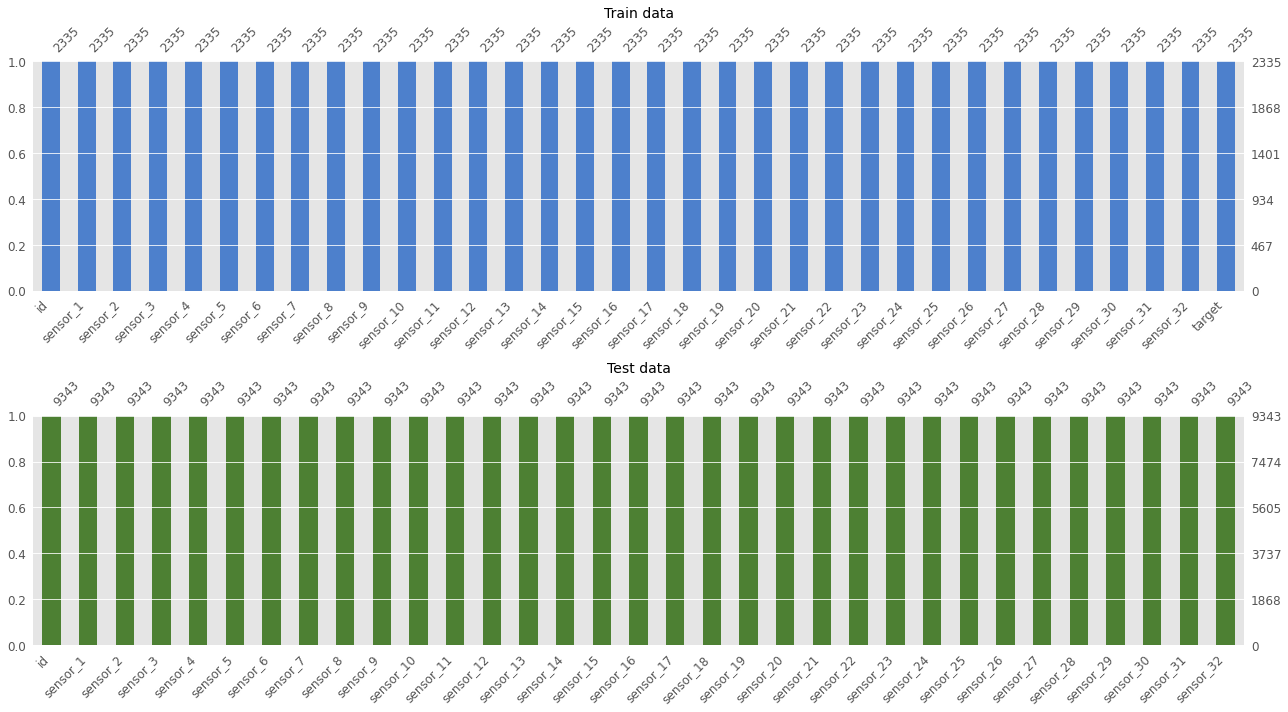

In [7]:
# 결측치 시각화
fig, axes = plt.subplots(nrows=2, figsize=(18,10))

# train data
msno.bar(train_df, color=(0.3,0.5,0.8), fontsize=12, ax=axes[0])
axes[0].set_title("Train data", fontsize=14)

# test data
msno.bar(test_df, color=(0.3,0.5,0.2), fontsize=12, ax=axes[1])
axes[1].set_title("Test data", fontsize=14)

fig.tight_layout()

- 결측치 시각화를 통해, train data와 test data 모두 결측치가 없음을 알 수 있다.

**target 컬럼**

In [8]:
print("정답 컬럼 고유값 확인:", np.unique(train_df['target']))

정답 컬럼 고유값 확인: [0 1 2 3]


- 예측하고자 하는 정답의 범주는 0,1,2,3으로 총 4개의 클래스로 구성되어 있다.
- 각 클래스 분포가 불균형인 경우에는 불균형을 처리해주어야 하기 때문에, 각 클래스의 분포를 시각화로 확인해보도록 한다.

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


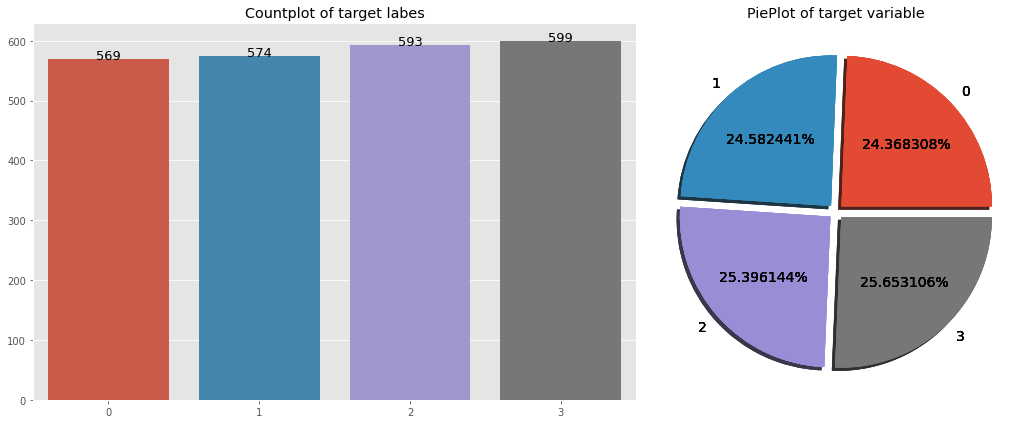

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# count plot
sns.countplot(x="target", data=train_df, ax=axes[0])
axes[0].set_title("Countplot of target labes")

for rect in axes[0].patches:
  axes[0].text(rect.get_x() + rect.get_width()/2,
               rect.get_height(),
               rect.get_height(),
               ha="center",
               fontsize=13
               )
  
  # pie chart
  plot_data = train_df['target'].value_counts().sort_index()
  plot_data.plot.pie(explode = [0.05, 0.05, 0.05, 0.05], shadow=True, autopct="%2f%%", fontsize=14 )
  axes[1].set_title("PiePlot of target variable")

  # 시각화 옵션 설정
  for index in [0,1]:
    axes[index].set_xlabel("")
    axes[index].set_ylabel("")

  fig.tight_layout()

- 클래스 0: 569 (24.37%)
- 클래스 1: 574 (24.58%)
- 클래스 2: 593 (25.40%)
- 클래스 3: 599 (25.65%)

: 클래스 3의 개수가 599개로 가장 많으며, 각 클래스의 분포가 모두 비슷함을 확인할 수 있다. 따라서 예측하고자 하는 변수를 따로 처리해주는 과정은 필요가 없다.

**Independnt variabls**

---

- train 데이터와 test 데이터에 존재하는 독립변수들의 분포를 확인.

In [10]:
# train 데이터 요약 통계량 확인
display(train_df.drop(['id', 'target'], axis=1).describe())

# test 데이터 요약 통계량 확인
display(test_df.drop(["id"], axis=1).describe())

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32
count,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000
mean,-1.122174,-1.024673,-0.672769,-0.147724,-0.327494,-0.423462,0.676275,-0.936019,-0.797432,-0.704585,-1.099322,-0.843473,-0.491915,-0.851473,-0.344029,-1.128676,-0.959658,-0.639778,-0.559455,-0.658692,-0.611461,-0.741168,0.027448,-0.356441,-0.927744,-0.589060,-0.081374,-0.370812,-0.726941,-0.809534,-0.495062,-0.743585
std,11.486353,7.399859,26.519159,15.551500,11.461970,7.314322,26.869479,15.598104,12.015022,7.384626,26.262009,15.498328,11.894939,7.401702,25.815937,15.513633,11.654236,7.586333,26.885734,15.936823,11.942224,7.548507,26.671928,16.531906,12.021560,7.440983,25.923355,15.541803,11.636507,7.469744,25.291238,16.300385
min,-94.746969,-63.942094,-122.195138,-111.870691,-94.147972,-70.916786,-105.956553,-102.965354,-81.268085,-47.937561,-115.943693,-102.916207,-115.053373,-59.689434,-107.985386,-126.950747,-95.956853,-83.854213,-108.964270,-108.094304,-103.876936,-59.993001,-93.171275,-127.797649,-99.115177,-86.193378,-105.751637,-105.890010,-74.977182,-74.006065,-121.097086,-123.876153
25%,-4.036597,-4.031957,-14.878500,-7.116633,-3.968687,-3.957699,-13.937806,-8.053214,-4.031148,-3.983620,-15.165419,-8.082508,-3.893967,-3.982224,-14.953749,-8.096568,-4.038010,-3.996916,-15.179515,-7.851749,-4.002134,-3.973502,-14.102903,-7.980628,-4.004750,-4.001112,-14.096840,-8.004561,-3.981055,-3.988965,-13.998874,-7.873898
50%,-0.951398,-1.015582,-0.961088,-0.890469,-0.871690,-0.804810,0.058910,-1.095551,-0.944613,-0.932964,-1.116522,-1.054003,-0.908079,-0.937905,-0.858820,-1.004242,-0.947597,-0.967231,-0.964579,-1.013369,-0.942706,-0.968065,-1.104314,-0.926120,-0.907301,-0.897015,-0.954791,-0.989293,-0.889780,-0.928504,-0.955684,-1.019547
75%,2.895540,2.140456,13.974075,6.110973,2.970387,3.006144,13.934438,4.955494,2.235557,2.883284,13.022905,6.021600,2.992981,2.854699,12.965905,5.508252,2.895085,2.876743,13.978336,5.917309,2.948692,2.920789,12.137937,6.002985,2.863184,2.951682,13.903783,5.922250,2.972719,2.519426,13.926128,5.121679
max,68.876142,39.913391,127.124171,102.015561,89.059852,34.923040,120.046277,125.160611,74.101715,47.030119,127.110419,99.932331,107.910041,40.026878,126.981907,120.974880,85.952050,39.993408,117.934200,121.026042,102.882569,40.917741,121.959404,127.161055,58.113657,59.105536,123.179253,111.137925,54.098746,35.896503,125.974107,104.959621


,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32
count,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000,9343.000000
mean,-0.628258,-0.656799,-0.525379,-0.790890,-0.734214,-0.801868,-0.382038,-0.808731,-0.605111,-0.740536,0.027124,-0.540943,-0.776290,-0.635792,-0.433570,-0.749601,-0.714818,-0.658445,-0.111501,-0.839346,-0.899049,-0.623447,-0.638059,-0.763211,-0.790750,-0.755255,-0.437697,-1.071997,-0.743311,-0.678331,-0.344835,-0.576254
std,11.832964,7.452133,25.631510,15.372176,11.933031,7.390419,25.755418,15.330627,11.902088,7.396929,25.549750,14.875152,11.978860,7.295009,26.199882,15.461319,12.268331,7.266772,26.213708,15.261372,12.203308,7.296026,26.038906,15.235777,11.946456,7.344751,25.936114,15.060080,12.097549,7.363458,25.618149,15.332268
min,-104.044027,-75.059695,-114.018432,-127.943995,-127.983210,-84.030386,-128.033637,-128.036004,-109.116907,-99.014745,-119.891322,-117.967624,-99.120018,-94.968659,-128.199543,-127.970392,-112.103291,-84.957935,-127.996994,-127.933887,-120.099697,-79.099258,-123.101594,-127.893767,-119.994449,-69.954064,-128.013570,-128.067795,-128.032877,-68.973719,-127.952703,-107.960724
25%,-3.979736,-3.966381,-14.974971,-7.969307,-3.971995,-3.978190,-14.104783,-8.007179,-4.001779,-4.012557,-14.001859,-7.899624,-3.993974,-3.975414,-14.966070,-7.959364,-4.010047,-3.970846,-14.137434,-8.000989,-4.018006,-3.976943,-15.035832,-7.982726,-3.995787,-3.994754,-14.850654,-8.017426,-3.982730,-3.988324,-14.005003,-7.834823
50%,-0.904598,-0.887505,-1.021169,-1.033398,-0.903961,-0.944097,-0.889134,-1.100708,-0.909196,-0.924022,-0.187238,-0.981945,-0.894447,-0.900616,-1.032946,-1.047852,-0.920913,-0.920273,-0.875067,-1.063311,-0.946501,-0.900535,-1.022250,-1.024196,-0.908620,-0.916166,-1.012729,-1.045174,-0.919393,-0.935407,-0.913188,-1.004701
75%,2.987203,2.935523,13.019911,5.852302,2.966576,2.833633,13.188271,5.118780,2.946251,2.950737,13.796687,5.930816,2.923612,2.947260,13.073840,5.858131,2.921878,2.922913,13.188760,5.198581,2.921507,2.956603,13.038944,5.214487,2.911339,2.888456,13.814711,5.172807,2.942584,2.862274,13.010044,5.942596
max,90.037923,54.977145,126.805849,126.130615,106.023697,61.102433,127.202233,126.957325,118.063610,38.874365,127.093476,108.129028,122.980740,44.035605,127.034984,126.983316,102.021476,55.890417,126.927507,127.050356,106.047582,54.009478,127.139450,126.935040,110.988863,76.122970,126.826318,114.034898,105.070831,51.066778,127.040313,126.967283


- train 데이터와 test 데이터 독립변수들의 이름이 sensor_ 로 시작함을 확인할 수 있다.
- 모든 변수의 평균값이 0 근처에 있으며, 표준편차의 값도 매우 크지 않다는 것을 알 수 있다.
- 모든 변수들이 평균에서 크게 차이가 나는 최솟값가 최대값이 보인다.이 부분은 확인해 봐야 할 듯 하다.

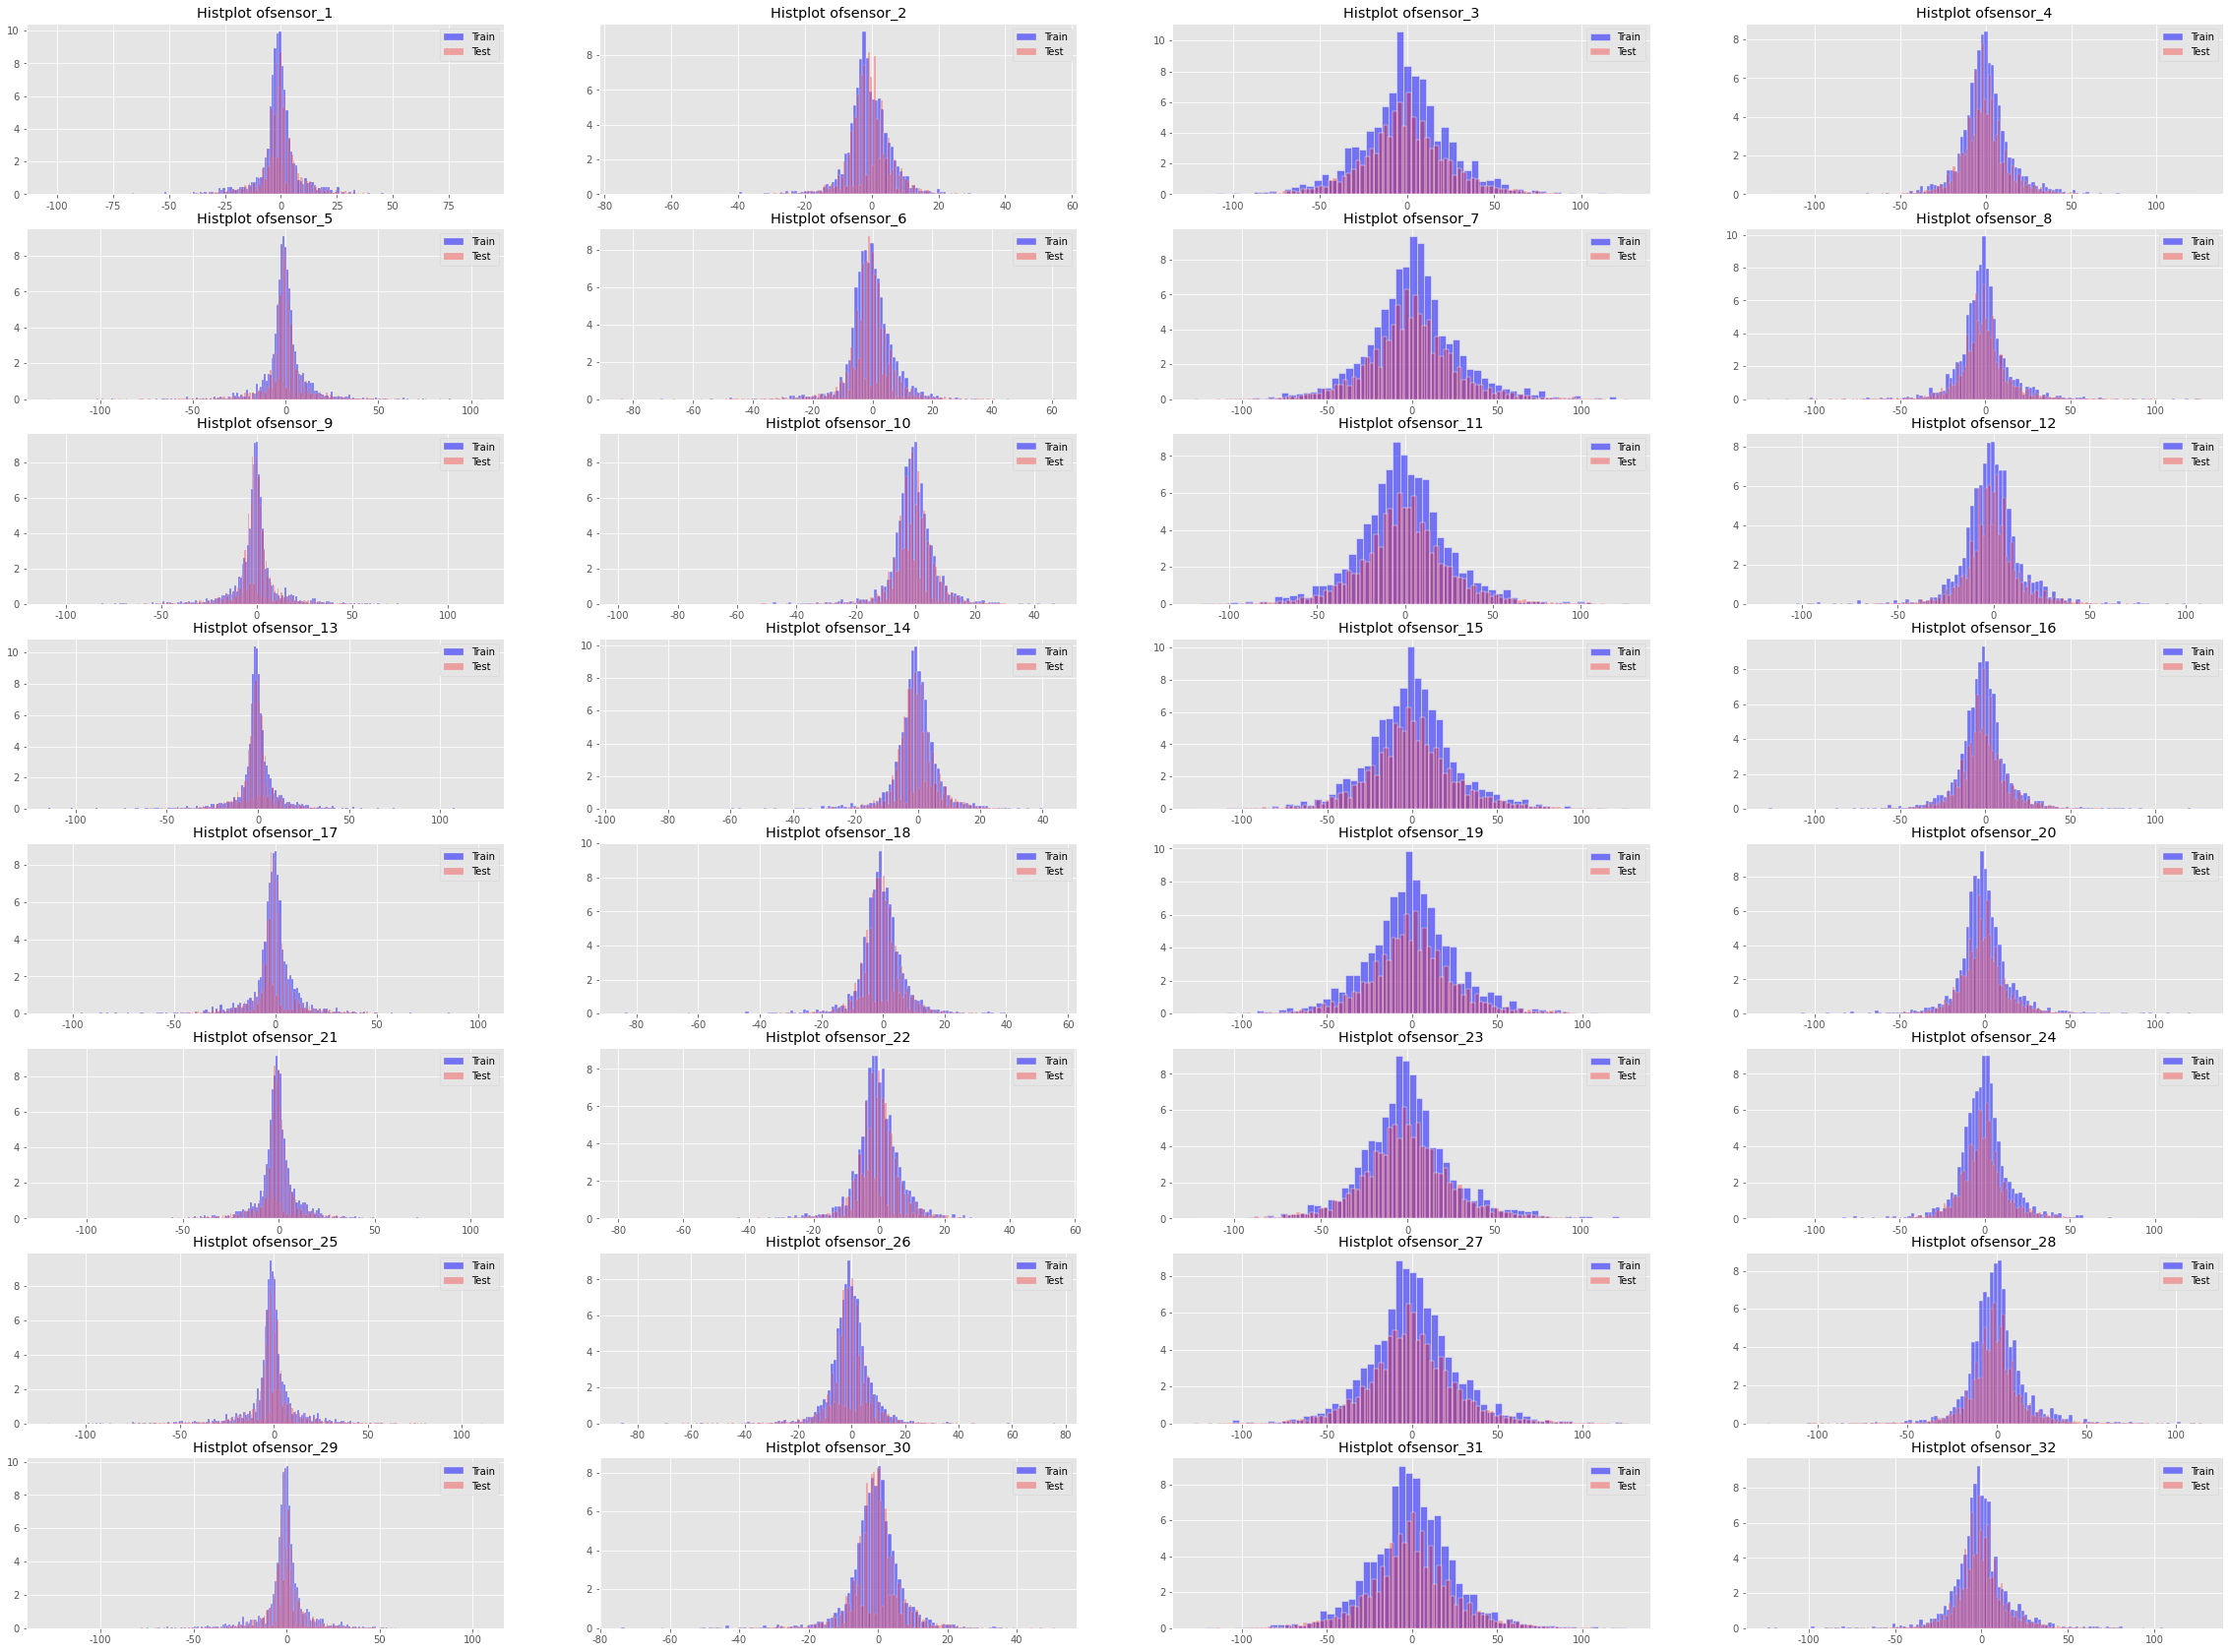

In [11]:
# train 데이터와 test 데이터 각 변수들의 분포가 비슷한지 확인

# 독립변수들의 Histplot(type = percent)
fit, axes = plt.subplots(nrows=8, ncols=4, figsize=(40, 30))

column_list = train_df.drop(['id', 'target'], axis=1).columns.tolist()

for idx, col in enumerate(column_list):
  rows = idx // 4
  cols = idx % 4
  # train data visualization
  sns.histplot(x=col,
               data=train_df,
               stat="percent",
               color="blue",
               alpha=0.5,
               label="Train",
               ax=axes[rows][cols]
               )
  # Test data visualization
  sns.histplot(x=col,
               data=test_df,
               stat="percent",
               color="red",
               alpha=0.3,
               label="Test",
               ax=axes[rows][cols]
               )
  
  axes[rows][cols].set_title(f'Histplot of{col}')
  axes[rows][cols].set_xlabel("")
  axes[rows][cols].set_ylabel("")
  axes[rows][cols].legend()

fig.tight_layout(pad=1.5)


- 우선 salborn 라이브러리의 histplot 함수를 사용하였다.
- 학습 데이터와 트레인 데이터의 개수 차이가 나기 때문에, 각 변수들의 분포가 비슷함을 확인할 수 있다.
- 또한, 요약 통계량에서 확인하였듯이 모든 변수가 0 부근에 갓이 몰려있음을 확인할 수 있다.
- 다음으로 각 독립변수들의 **왜도**와 **첨도**를 확인해보자.
- 왜도의 값이 양수인 경우에는 데이터의 중심이 정규분포보다 왼쪽으로 치우쳐져 있다. 왜도의 갓이 음수인 경우에는 데이터의 중심이 정규분포보다 오른쪽으로 치우쳐져 있다.
- 왜도의 값이 [-2, 2] 사이에 있는 경우에는 왜도가 크지 않다고 판단한다.
- 첨도의 값이 0보다 큰 경우에는 정규분포보다 뾰족한 분포를 나타내며, 0보다 적은 경우에는 정규분포보다 완만한 분포를 나타낸다.
- 첨도의 값이 크면 이상치가 많음을 의미한다.

In [12]:
column_list = train_df.drop(["id", "target"], axis=1).columns.tolist()

for col in column_list:

  # 학습 데이터의 왜도와 첨도
  train_skew = stats.skew(train_df[col])
  train_kurt = stats.kurtosis(train_df[col])

  # 테스트 데이터의 왜도와 첨도
  test_skew = stats.skew(test_df[col])
  test_kurt = stats.kurtosis(test_df[col])

  print("{}\t Train 왜도 = {:.6f}, 첨도 = {:.6f}\t\tTest 왜도 = {:.6f}, 첨도 = {:.6f}".format(col.upper(), train_skew, train_kurt, test_skew, test_kurt), "\n")



SENSOR_1	 Train 왜도 = -1.151826, 첨도 = 11.599183		Test 왜도 = -0.645781, 첨도 = 11.807091 

SENSOR_2	 Train 왜도 = -1.177917, 첨도 = 10.318038		Test 왜도 = -0.815036, 첨도 = 10.679668 

SENSOR_3	 Train 왜도 = 0.013689, 첨도 = 1.651655		Test 왜도 = 0.200512, 첨도 = 1.547186 

SENSOR_4	 Train 왜도 = -0.041410, 첨도 = 6.973400		Test 왜도 = 0.133447, 첨도 = 7.559113 

SENSOR_5	 Train 왜도 = 0.012275, 첨도 = 11.091572		Test 왜도 = -0.701884, 첨도 = 11.705738 

SENSOR_6	 Train 왜도 = -0.934917, 첨도 = 9.186789		Test 왜도 = -0.705805, 첨도 = 9.088850 

SENSOR_7	 Train 왜도 = 0.235762, 첨도 = 1.765939		Test 왜도 = 0.114974, 첨도 = 1.794859 

SENSOR_8	 Train 왜도 = 0.726878, 첨도 = 9.210351		Test 왜도 = 0.247291, 첨도 = 7.885914 

SENSOR_9	 Train 왜도 = -0.245176, 첨도 = 8.324665		Test 왜도 = -0.129571, 첨도 = 11.625914 

SENSOR_10	 Train 왜도 = -0.368068, 첨도 = 6.742086		Test 왜도 = -1.308653, 첨도 = 13.304167 

SENSOR_11	 Train 왜도 = 0.048298, 첨도 = 1.727470		Test 왜도 = 0.204262, 첨도 = 1.704304 

SENSOR_12	 Train 왜도 = -0.033922, 첨도 = 6.812524		Test 왜도 = 0.303251, 첨도 = 7.2

- 학습 데이터와 테스트 데이터 모든 변수들의 왜도는 대부분 0에 가까움을 확인할 수 있다.
- 하지만 첨도의 경우에는 약 1 ~ 6까지 모든 변수에서 0보다 큰 값을 가지고 있다.
- 따라서 각 변수들에 이상치가 존재한다는 사실을 유추해볼 수 있다.

**독립변수들과 예측 변수와의 관계 확인**

In [13]:
# Independant VS Target
fit, axes = plt.subplots(nrows=8, ncols=4, figsize=(40,40))

column_list = train_df.drop(["id", "target"], axis=1).columns.tolist()

for idx, column in enumerate(column_list):
  row = idx // 4
  col = idx % 4

  # Boxplot
  sns.boxplot(x="target", y=column, data=train_df, ax=axes[row][col])

  # Swarmplot
  sns.swarmplot(x="target", y=column, alpha=0.5, data=train_df, ax=axes[row][col])

  axes[row][col].set_title("Boxplot of {}".format(column))
  axes[row][col].set_xlabel("")
  axes[row][col].set_ylabel("")

fig.tight_layout(pad=1.5)

Output hidden; open in https://colab.research.google.com to view.

- 의도했던 결과는 아니지만 위의 시각화에서 각 해열로 비슷한 결과가 나타나는 것을 확인할 수 있다.
- **First col**: sensor_1, sensor_5, sensor_9, sensor_13, sensor_17, sensor_21, sensor_25, sensor_29 8개의 변수는 0과 2클래스에서 이상치가 많이 식별된다.
- **Second col**: sensor_2, sensor_6, sensor_10, sensor_14, sensor_18, sensor_22, sensor_26, sensor_30 8개의 변수는 0과 3클래스에 이상치가 많이 식별된다.
- **Third col**: sensor_3, sensor_7, sensor_11, sensor_15, sensor_19, sensor_23, sensor_27, sensor_31 8개의 변수는 모든 클래스에서 분포가 비슷하다.
- **Fourth col**: sensor_4, sensor_8, sensor_12, sensor_16, sensor_20, sensor_24, sensor_28, sensor_32 8개의 변수는 0클래스에서만 이상치가 많이 식별된다.
- 각 변수들의 이상치가 특정 클래스에서 발견됨을 확인할 수 있다.
- 이상치를 각 클래스 별로 처리해주는 방법이 좋은 것으로 판단된다.

---

- 다음으로 현재 데이터는 센서 데이터로 서로 비슷한 분포를 나타내는 변수도 존재하지만 그렇지 않은 변수들도 존재한다.
- 또한, 각 변수들의 최솟값과 최댓값이 다름을 확인할 수 있다.
- 따라서 독립변수들을 스케일링을 수행하여 비교를 진행해보도록 하자. 현재 과정에서는 StandardScaler, MinMaxScaler, RobustScaler 총 3개의 함수를 사용한다.
- 계속 반복되는 작업이므로 함수를 생성해주도록 한다.

In [14]:
# 각 변수들을 스케일링 수행한 후, 분포를 확인해주는 함수 생성
def feature_scale_plot(scaler=None, train=None, test=None):

  # 데이터 보존을 위해 데이터를 복사하고 'id' 변수는 인덱스로 지정해주도록 한다.
  function_train = train.set_index("id").copy()
  function_test = test.set_index("id").copy()

  train_target = function_train["target"]

  # 학습 데이터의 경우에는 'target' 변수를 임의로 삭제해주도록 한다.
  function_train = function_train.drop('target', axis=1)

  #-------------------------------
  # 1. 변수 Scaling
  #-------------------------------

  # 사용자가 지정한 'scaler' 객체 생성
  scaler = scaler

  # 학습 데이터를 이용하여 학습 진행
  scaler.fit(function_train)

  # 학습된 객체를 사용하여 학습 데이터와 테스트 데이터 스케일링
  scaled_train = pd.DataFrame(scaler.transform(function_train),columns=function_train.columns, index=function_train.index)
  scaled_test = pd.DataFrame(scaler.transform(function_test), columns=function_test.columns, index=function_test.index)

  #-------------------------------
  # 2. 변수 시각화
  #-------------------------------

  fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(40,40))

  # 반복문을 통해 왜도, 첨도 시각화 진행
  for index, column in enumerate(scaled_train.columns):

    # 학습 데이터의 왜도와 첨도
    train_skew = stats.skew(scaled_train[column])
    train_kurt = stats.kurtosis(scaled_train[column])

    # 테스트 데이터의 왜도와 첨도
    test_skew = stats.skew(scaled_test[column])
    test_kurt = stats.kurtosis(scaled_test[column])
    
    row = index // 4
    col = index % 4

    # 학습 데이터 Histogram
    sns.histplot(x = column, data = scaled_train, stat = "percent", color = "blue", alpha = 0.5, label = "Train", ax = axes[row][col])
    
    # 테스트 데이터 Histogram
    sns.histplot(x = column, data = scaled_test, stat = "percent", color = "red", alpha = 0.5, label = "Test", ax = axes[row][col])
    
    axes[row][col].set_title("{}\nTrain 왜도 = {:.4f}, 첨도 = {:.4f}\nTest 왜도 = {:.4f}, 첨도 = {:.4f}".format(column.upper(), train_skew, train_kurt, test_skew, test_kurt), fontsize = 18)
    axes[row][col].set_xlabel("")
    axes[row][col].set_ylabel("")
    axes[row][col].legend()
        
  fig.tight_layout(pad = 1.5)
  
  # 학습 데이터를 반환할 때 'target' 변수를 생성해줘야 한다.
  scaled_train["target"] = train_target
  
  return scaled_train.reset_index(), scaled_test.reset_index()

**StandardScaler**

---
- `StandarScaler()` 함수는 특성들의 평균을 0, 분산을 1로 스케일링 해주는 함수이다.
- 해당 방법은 이상치에 매우 민감하다.
- 현재 변수들 중에 평균이 0에 가까운 변수도 있고, 이상치가 존재하는 변수들도 있지만 진행해보도록 한다.

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


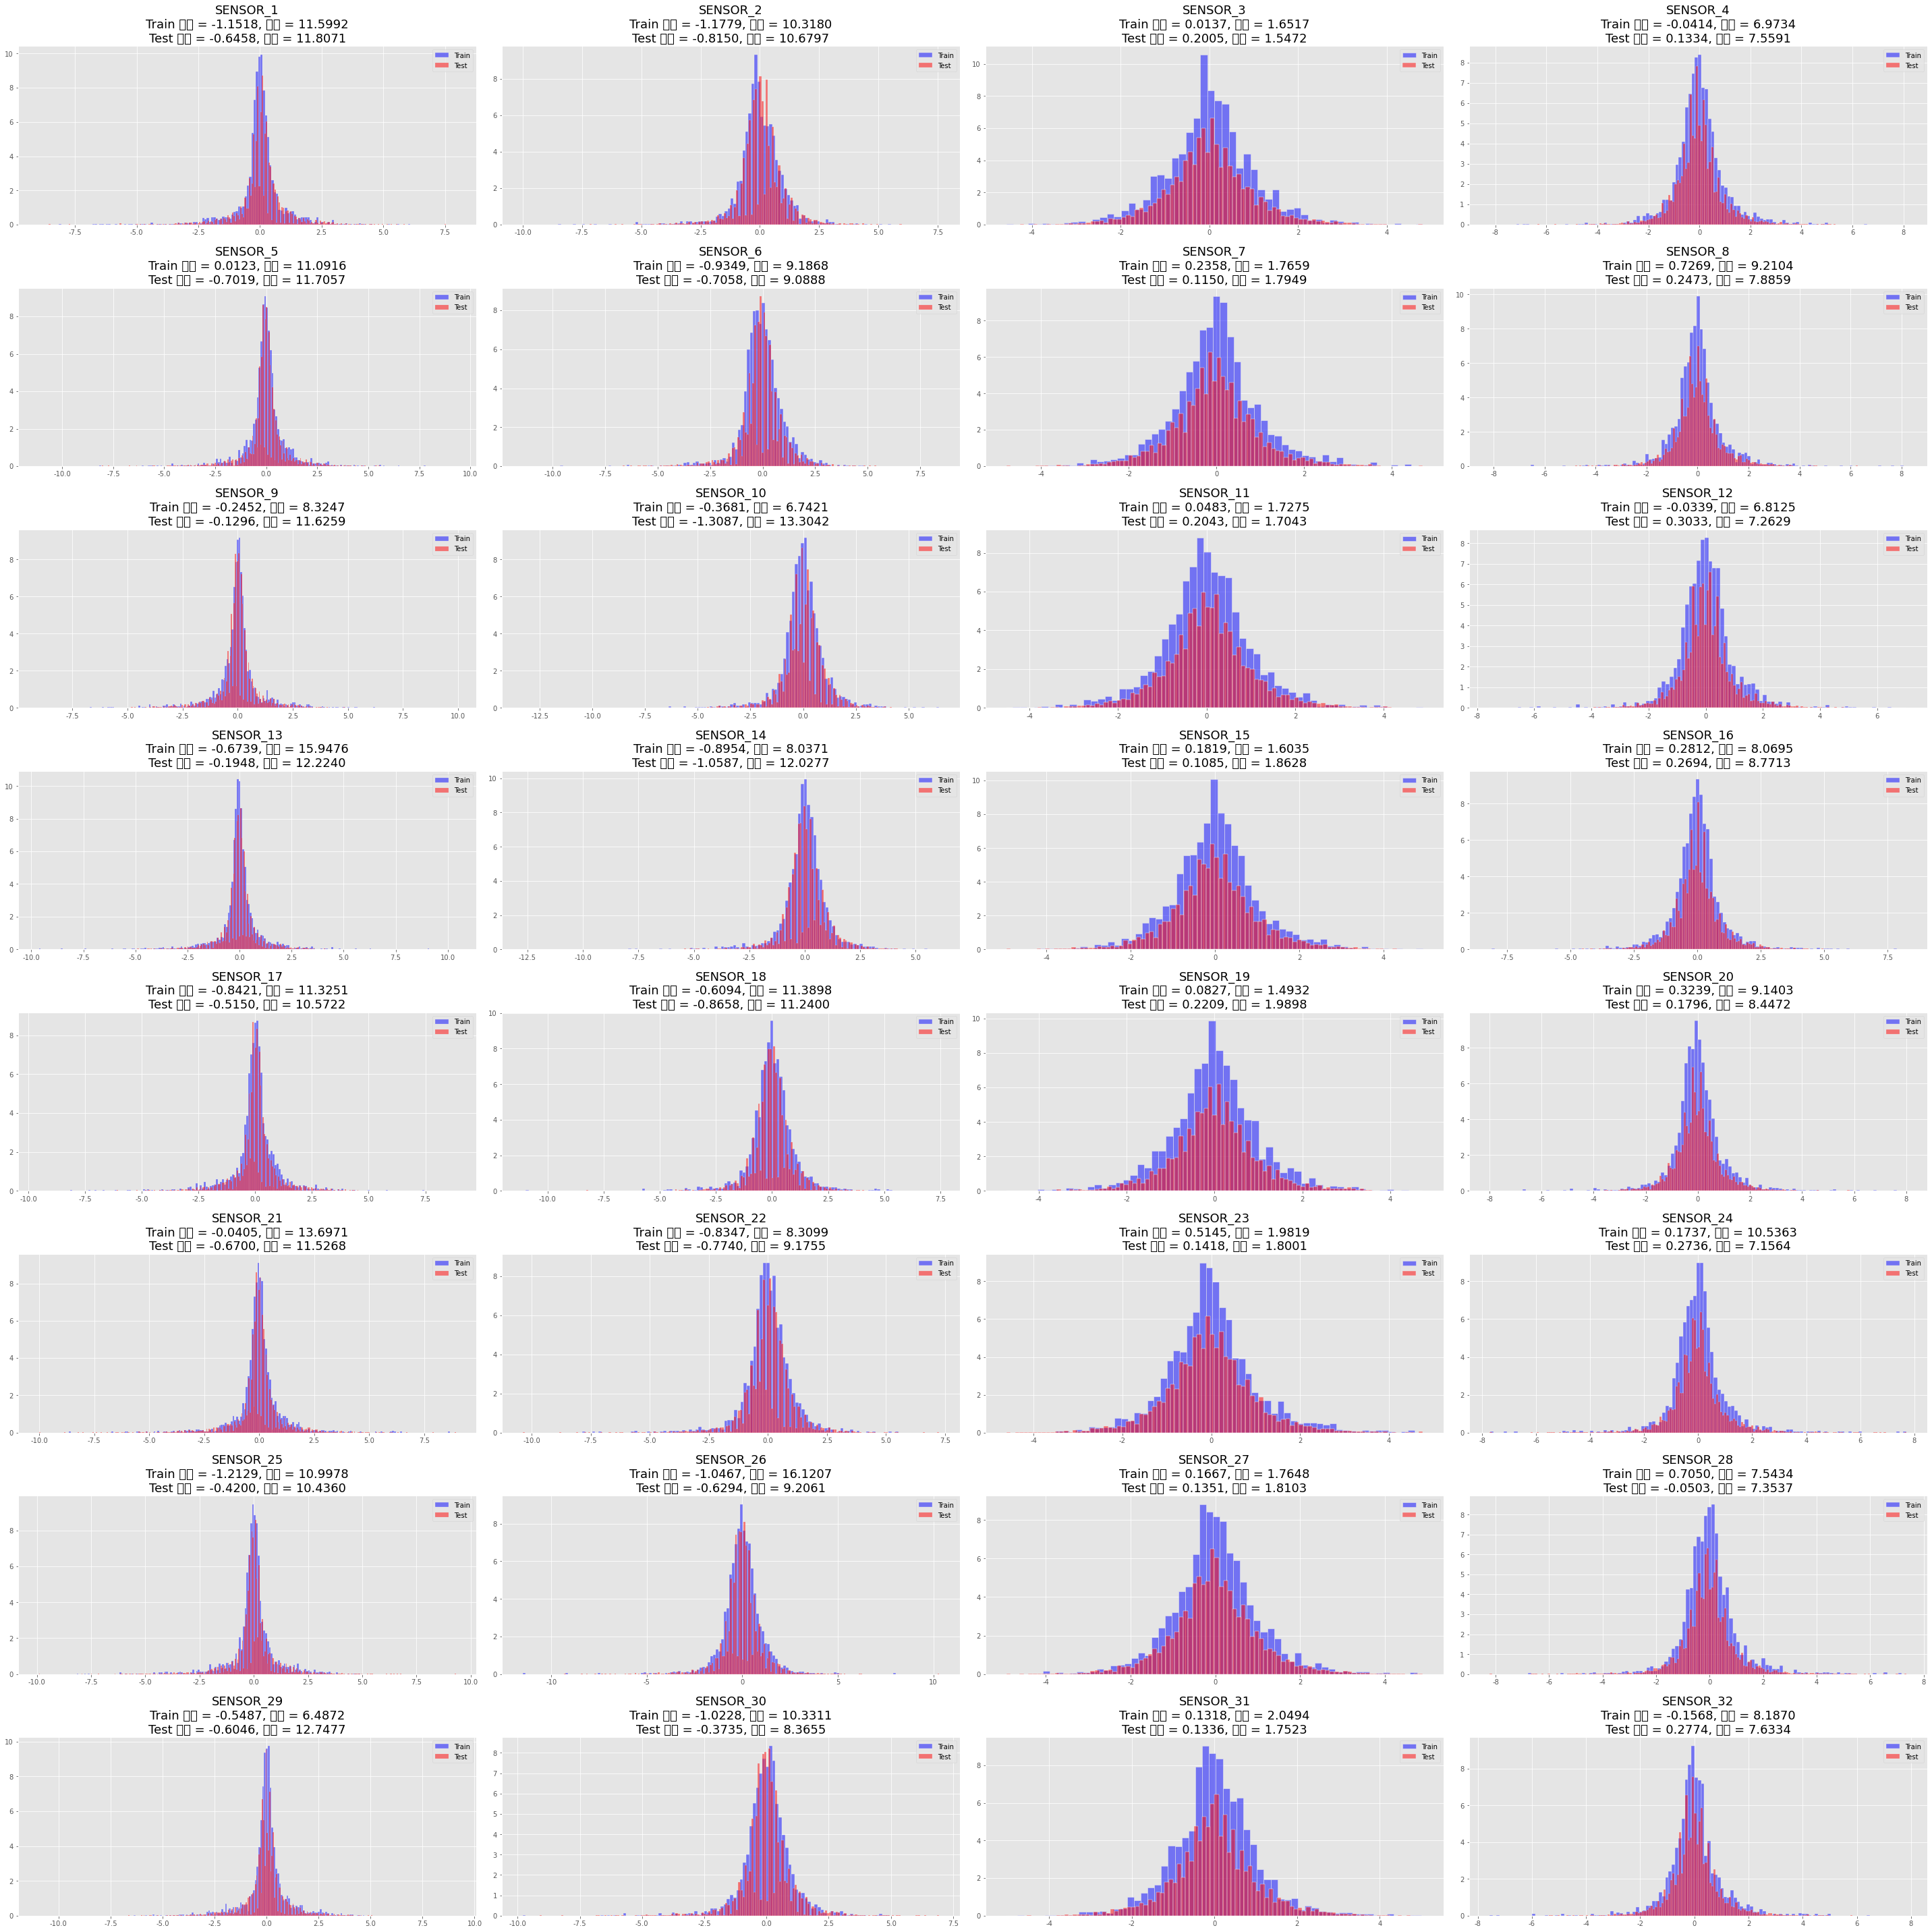

In [15]:
# 'StandardScaler' 함수 사용하여 스케일링 진행
standard_train, standard_test = feature_scale_plot(scaler = StandardScaler(), 
                                                   train = train_df, 
                                                   test = test_df)

- `StandardScaler()` 함수를 사용한 결과를 보면, 원래의 모든 독립변수들의 평균이 0에 가까웠기 때문에 왜도와 첨도에 큰 차이가 없는 것으로 보인다.
- 표준화 작어을 수행해준 변수들과 예측변수와의 관계를 확인해보도록 하자.


findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


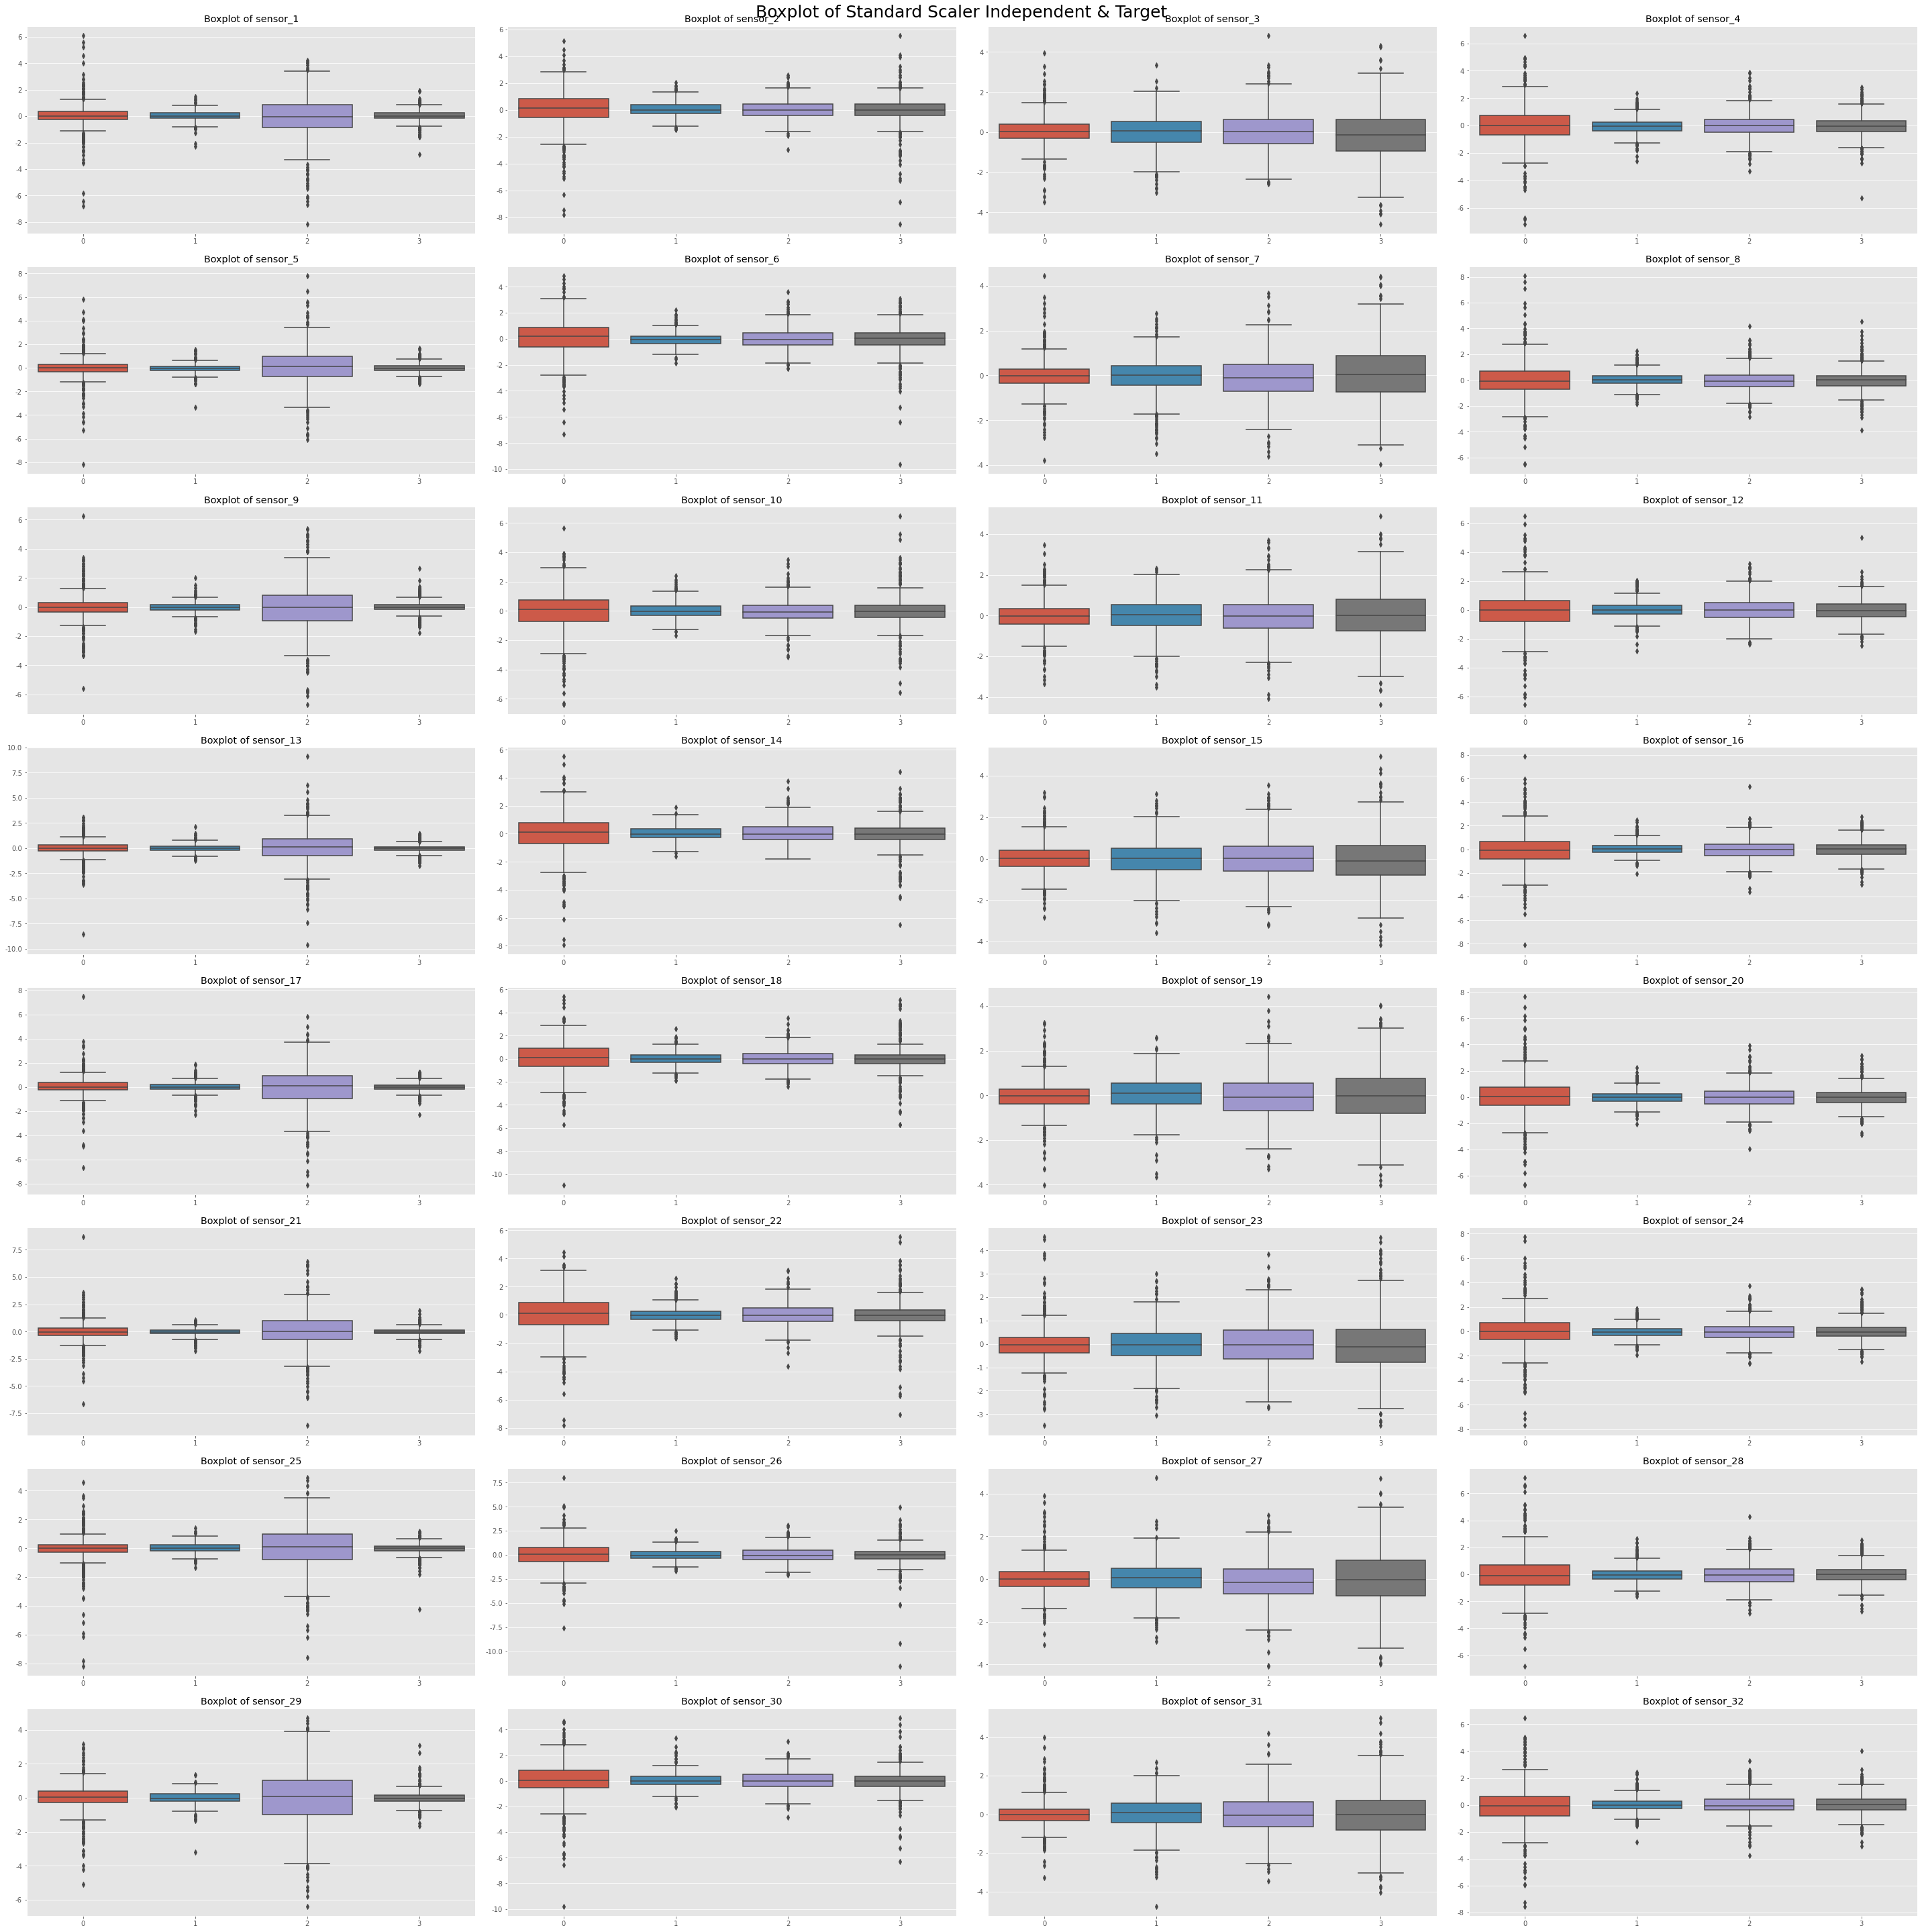

In [16]:
# Standard Scaler Independent VS Target
fig, axes = plt.subplots(nrows = 8, ncols = 4, figsize = (40, 40))

column_list = standard_train.drop(["id", "target"], axis = 1).columns.tolist()

for index, column in enumerate(column_list):
    
    row = index // 4
    col = index % 4
    
    # Boxplot
    sns.boxplot(x = "target", y = column, data = standard_train, ax = axes[row][col])
    
    axes[row][col].set_title("Boxplot of {}".format(column))
    axes[row][col].set_xlabel("")
    axes[row][col].set_ylabel("")
    
fig.suptitle(t = "Boxplot of Standard Scaler Independent & Target", y = 1, fontsize = 25)
fig.tight_layout(pad = 1.5)

- 표준화를 수행하여도 이상치가 식별됨을 확인할 수 있고, 기존에 비슷한 분포를 나타냈던 변수들도 똑같은 분포 형태를 나타내고 있음을 볼 수 있다.

### 2.3.2 MinMaxScaler

---
- MinMaxScaler() 함수는 특성들을 특정 범위([0,1])로 스케일링 해준다.
- 가장 작은 값은 0, 가장 큰 값은 1로 변환되므로 모든 특성들은 [0,1] 범위를 가지게 된다.

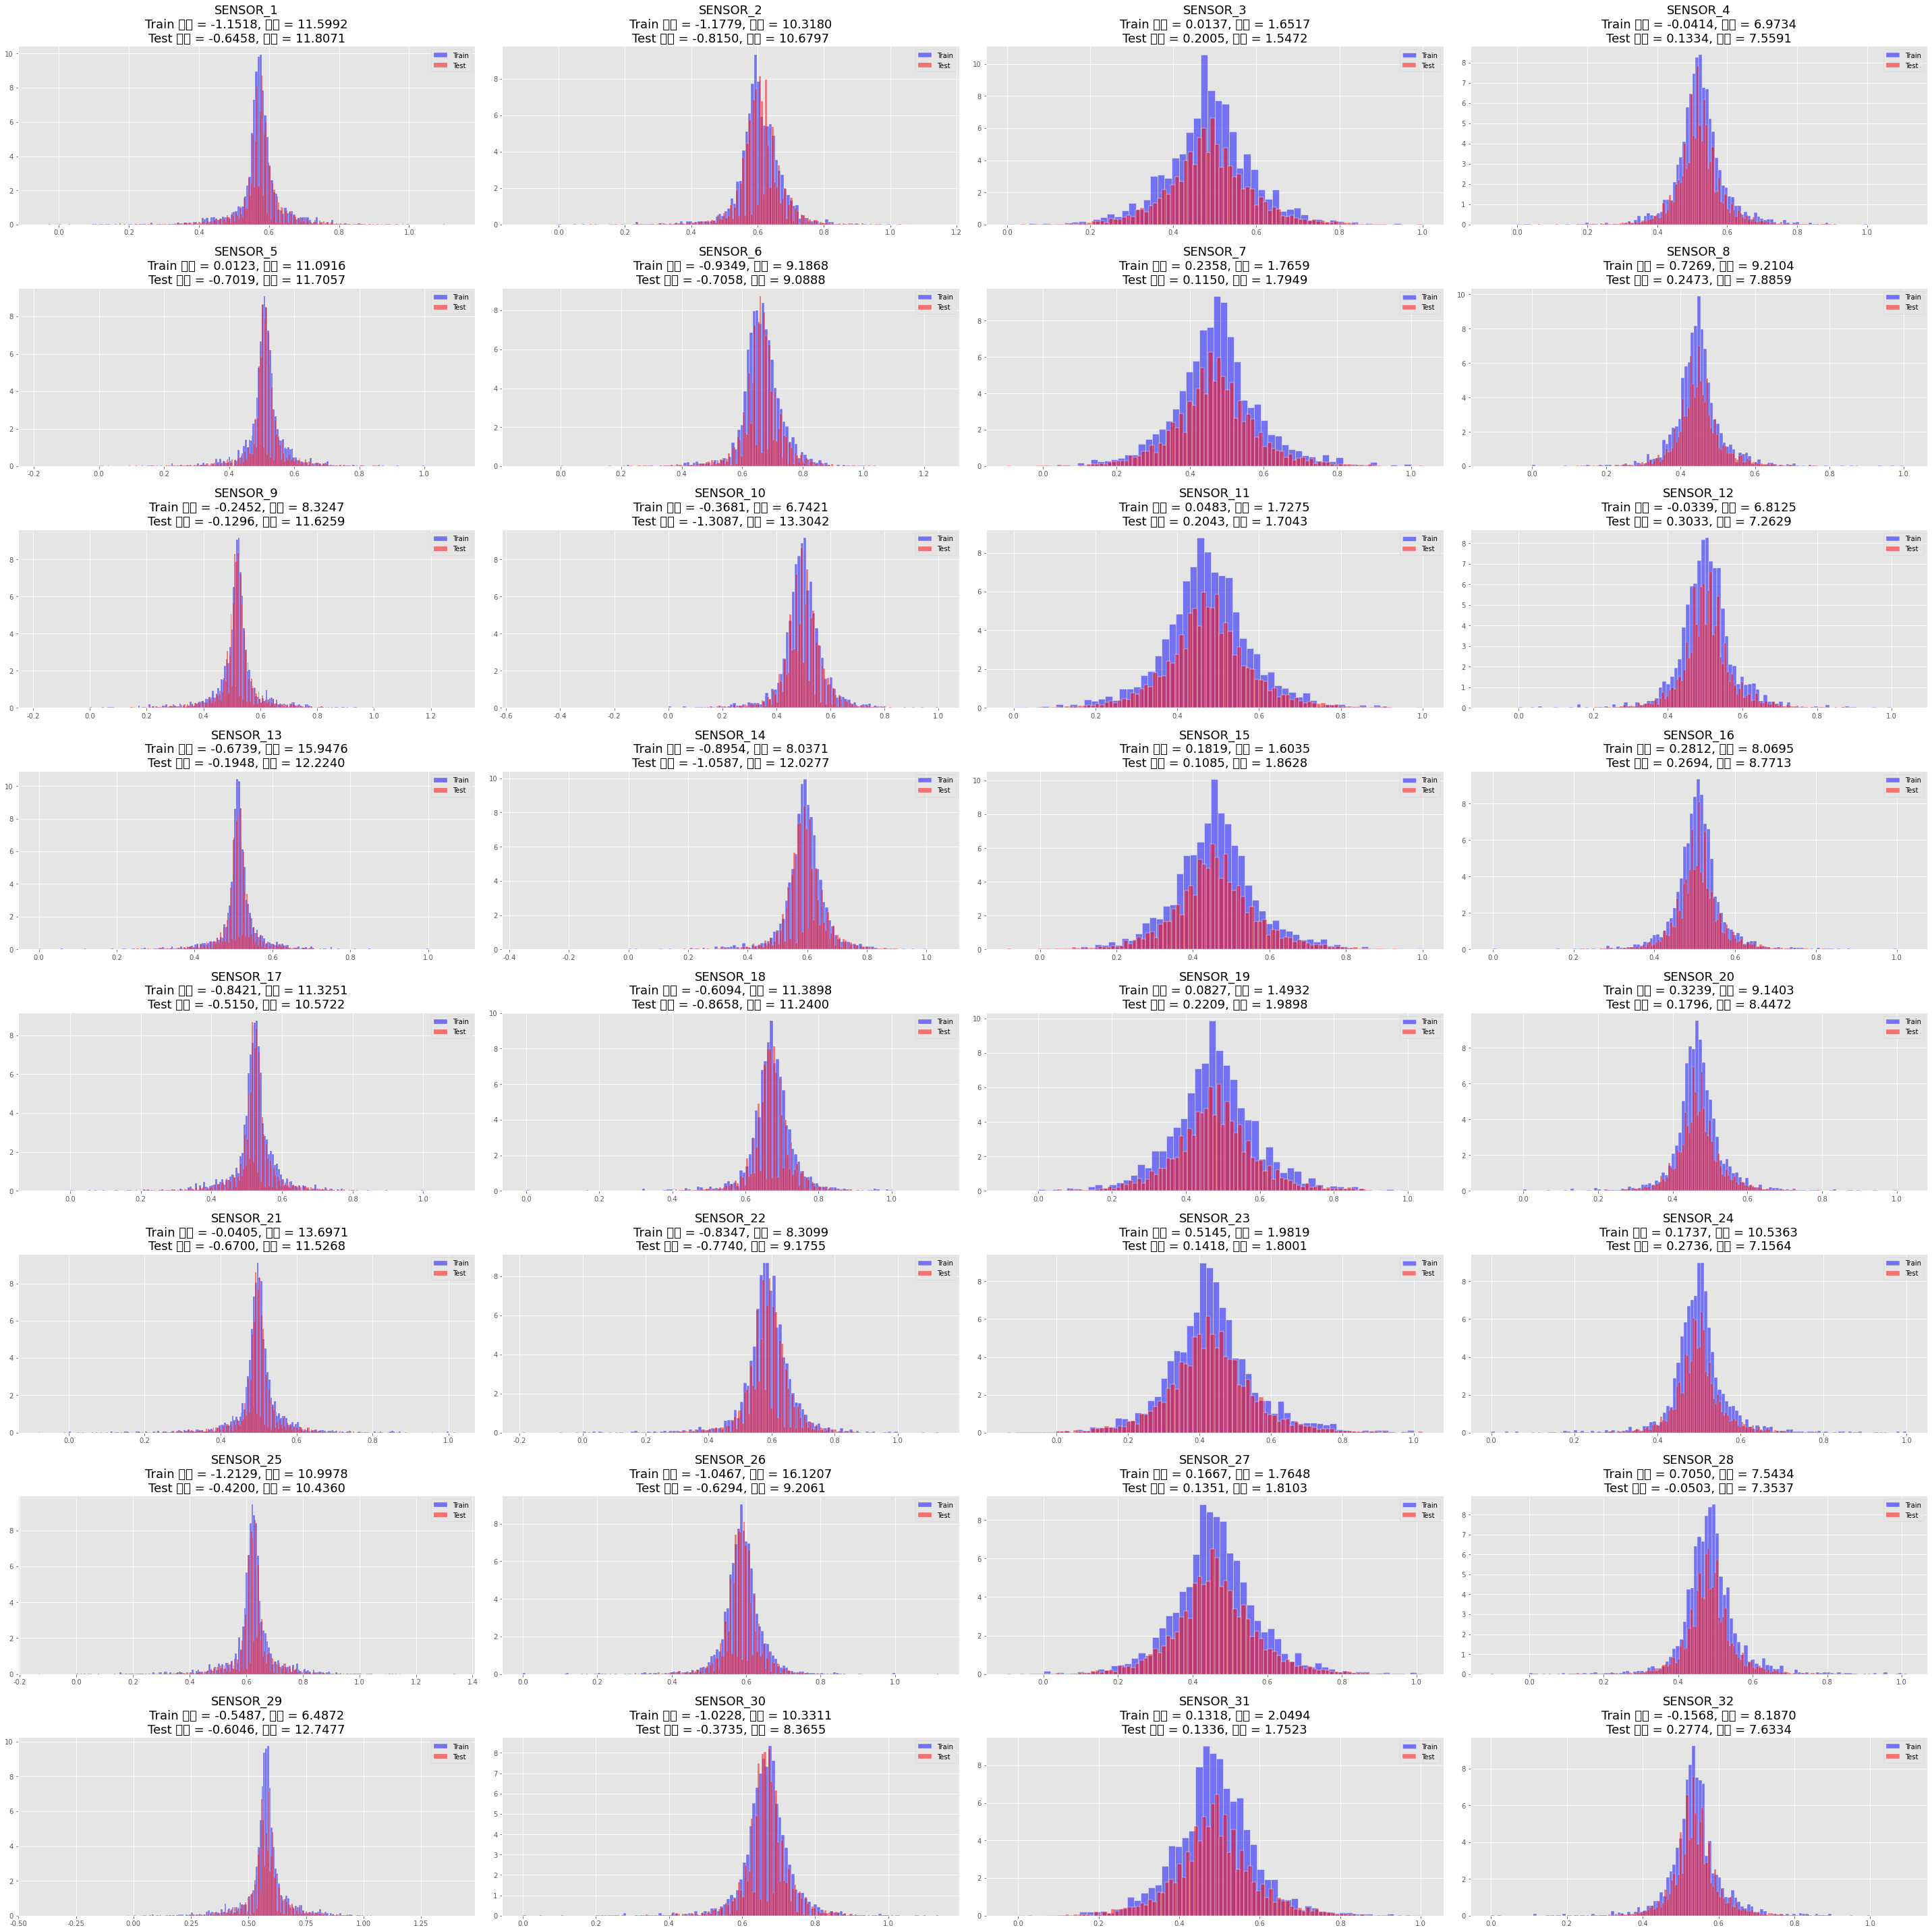

In [17]:
# MinMaxScaler() 함수를 사용하여 스케일링 진행
minmax_train, minmax_test = feature_scale_plot(scaler = MinMaxScaler(), train = train_df, test = test_df)

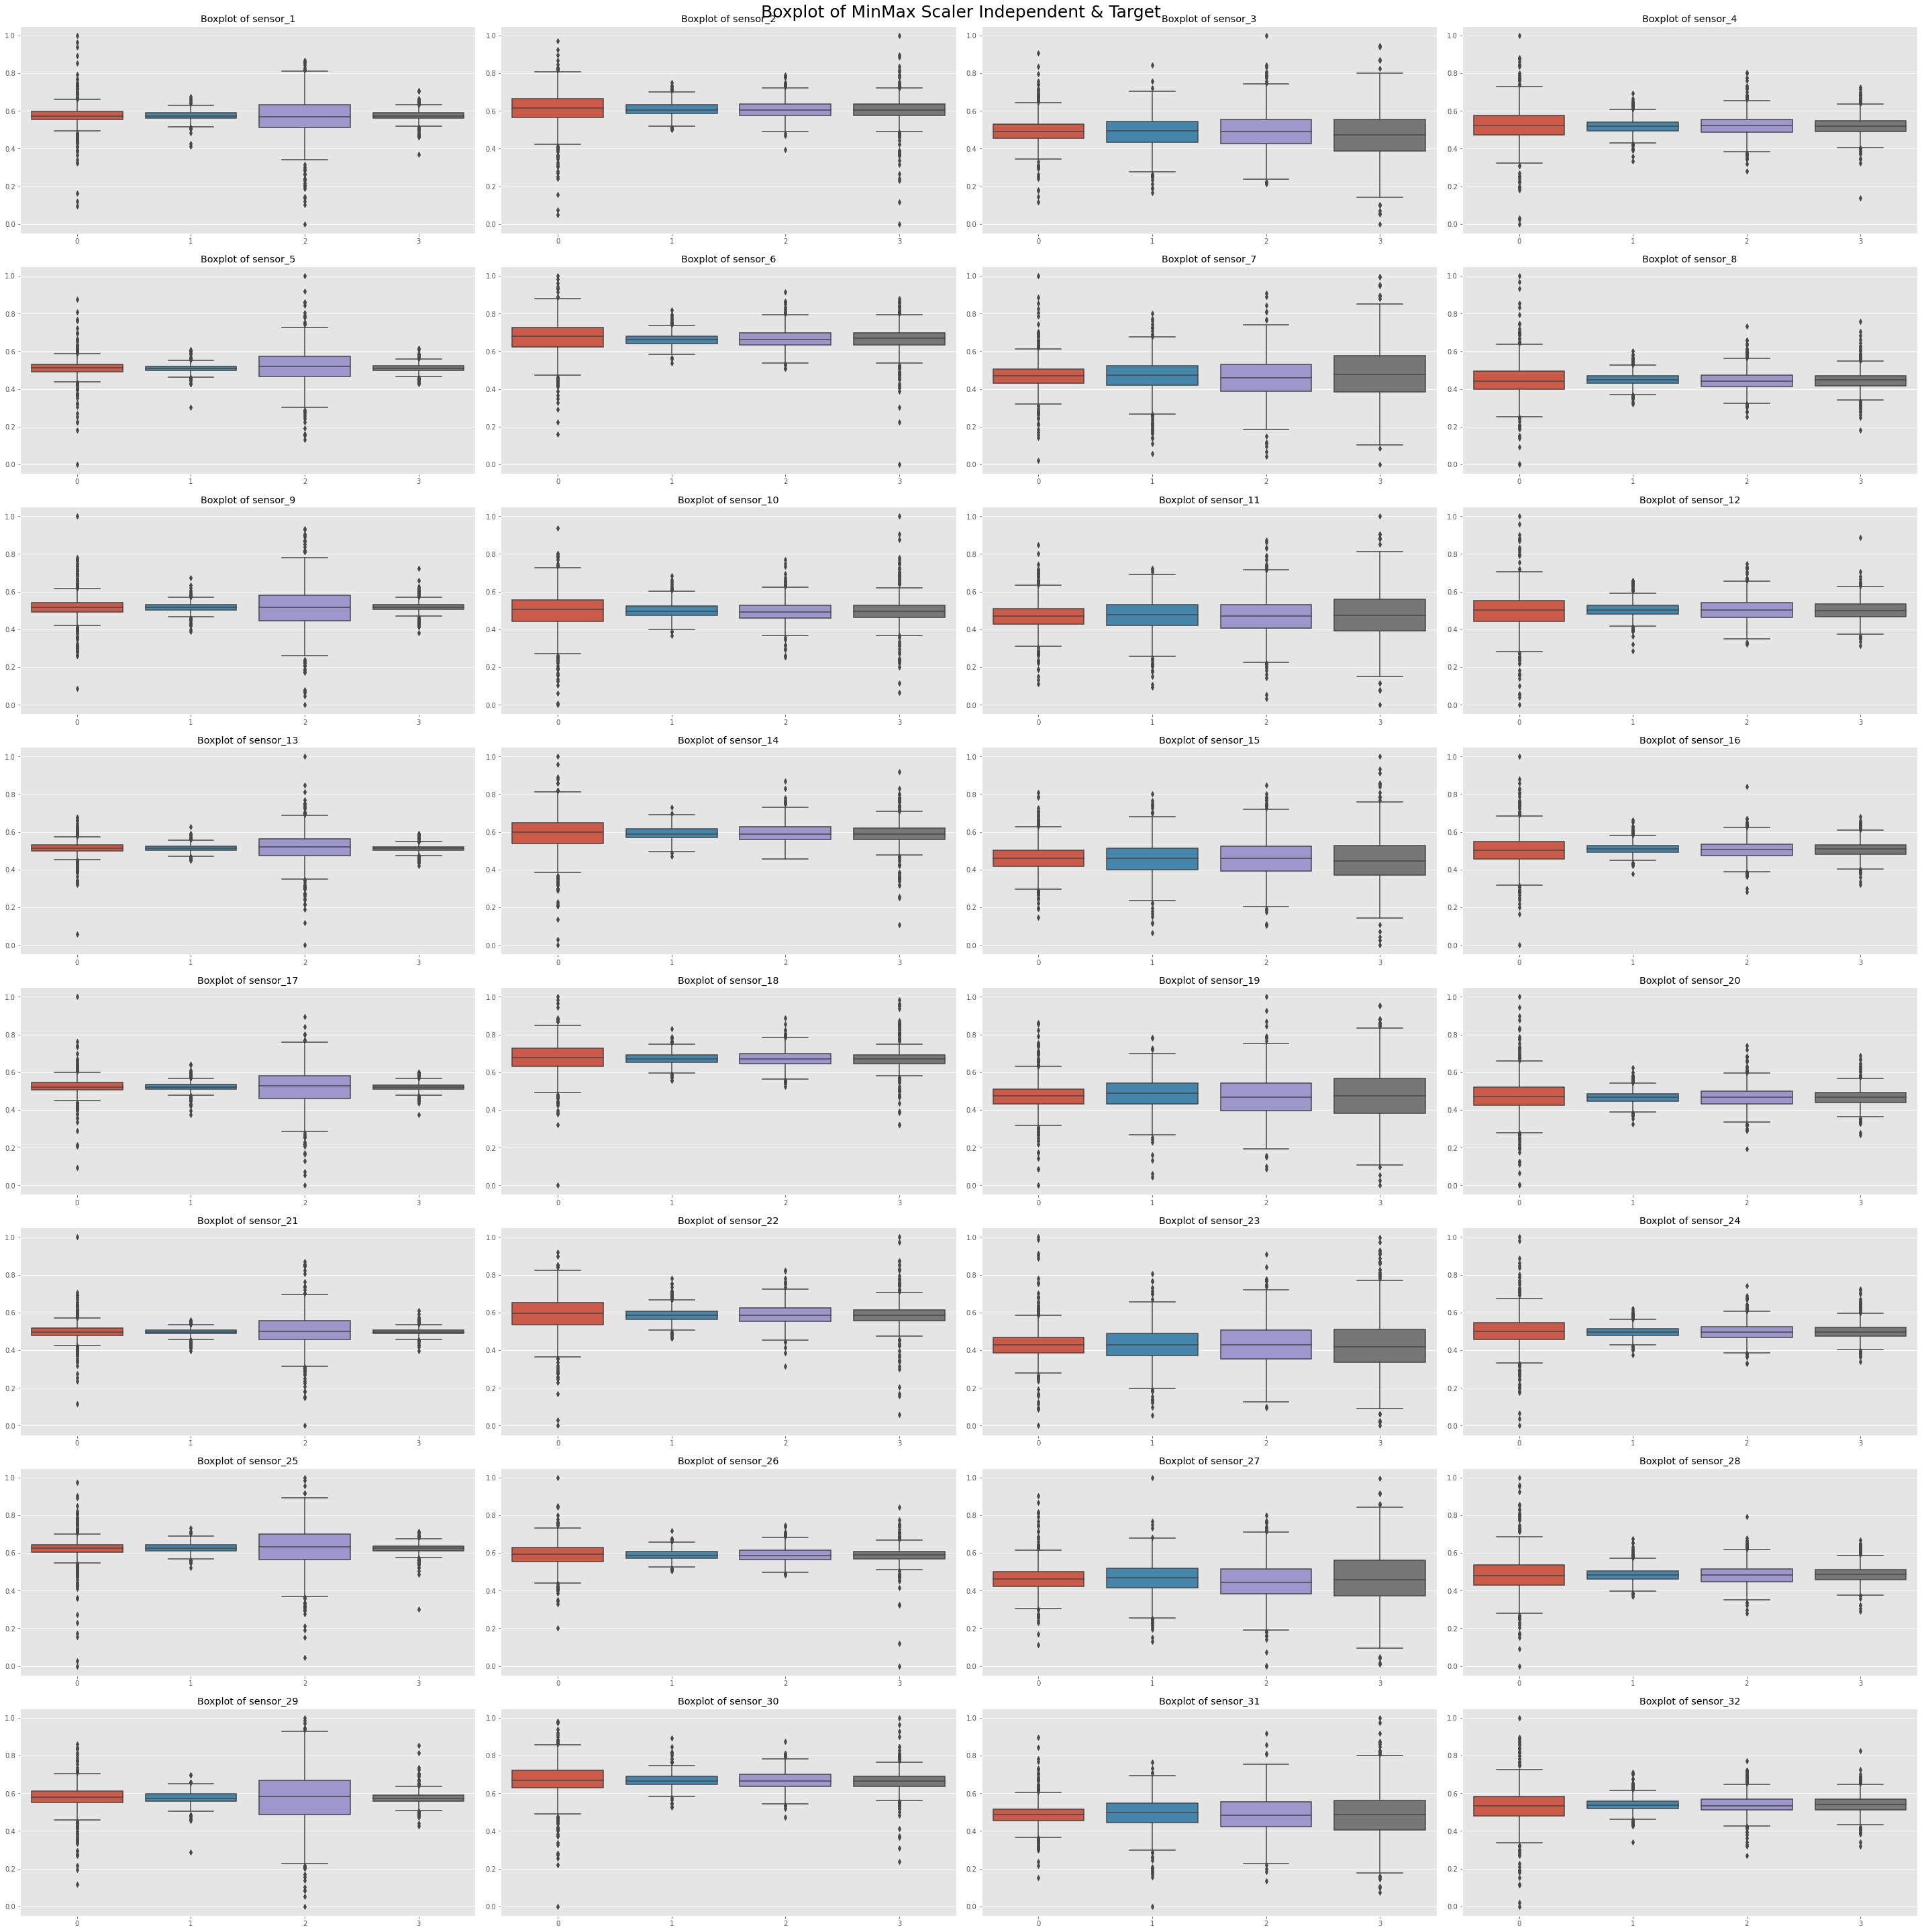

In [19]:
# MinMax Scaler Independent VS Target
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(40,40))

column_list = minmax_train.drop(["id", "target"], axis=1).columns.tolist()

for index, column in enumerate(column_list):

  row = index // 4
  col = index % 4

  # Boxplot
  sns.boxplot(x = "target", y = column, data = minmax_train, ax = axes[row][col])

  axes[row][col].set_title(f'Boxplot of {column}')
  axes[row][col].set_xlabel("")
  axes[row][col].set_ylabel("")

  fig.suptitle(t = "Boxplot of MinMax Scaler Independent & Target", y=1, fontsize=25)
  fig.tight_layout(pad=1.5)

- MinMaxScaler() 함수를 사용하여 표준화 작업을 진행하여도 왜도와 첨도에 변화가 없음을 확인할 수 있다.
- **Boxplot**은 위의 **StandardScaler**과 큰 차이가 없는 것으로 판단된다.

### 2.3.4 RobustScaler

---
- RobustScaler() 함수는 평균과 분산대신 중간값과 사분위값을 이용한다.
- 중간값은 정렬 시, 중앙에 있는 값을 의미하며, 사분위값은 1/4, 3/4에 위치한 값을 의미한다.
- **해당 방법은 이상치의 영향을 최소화할 수 있다.**

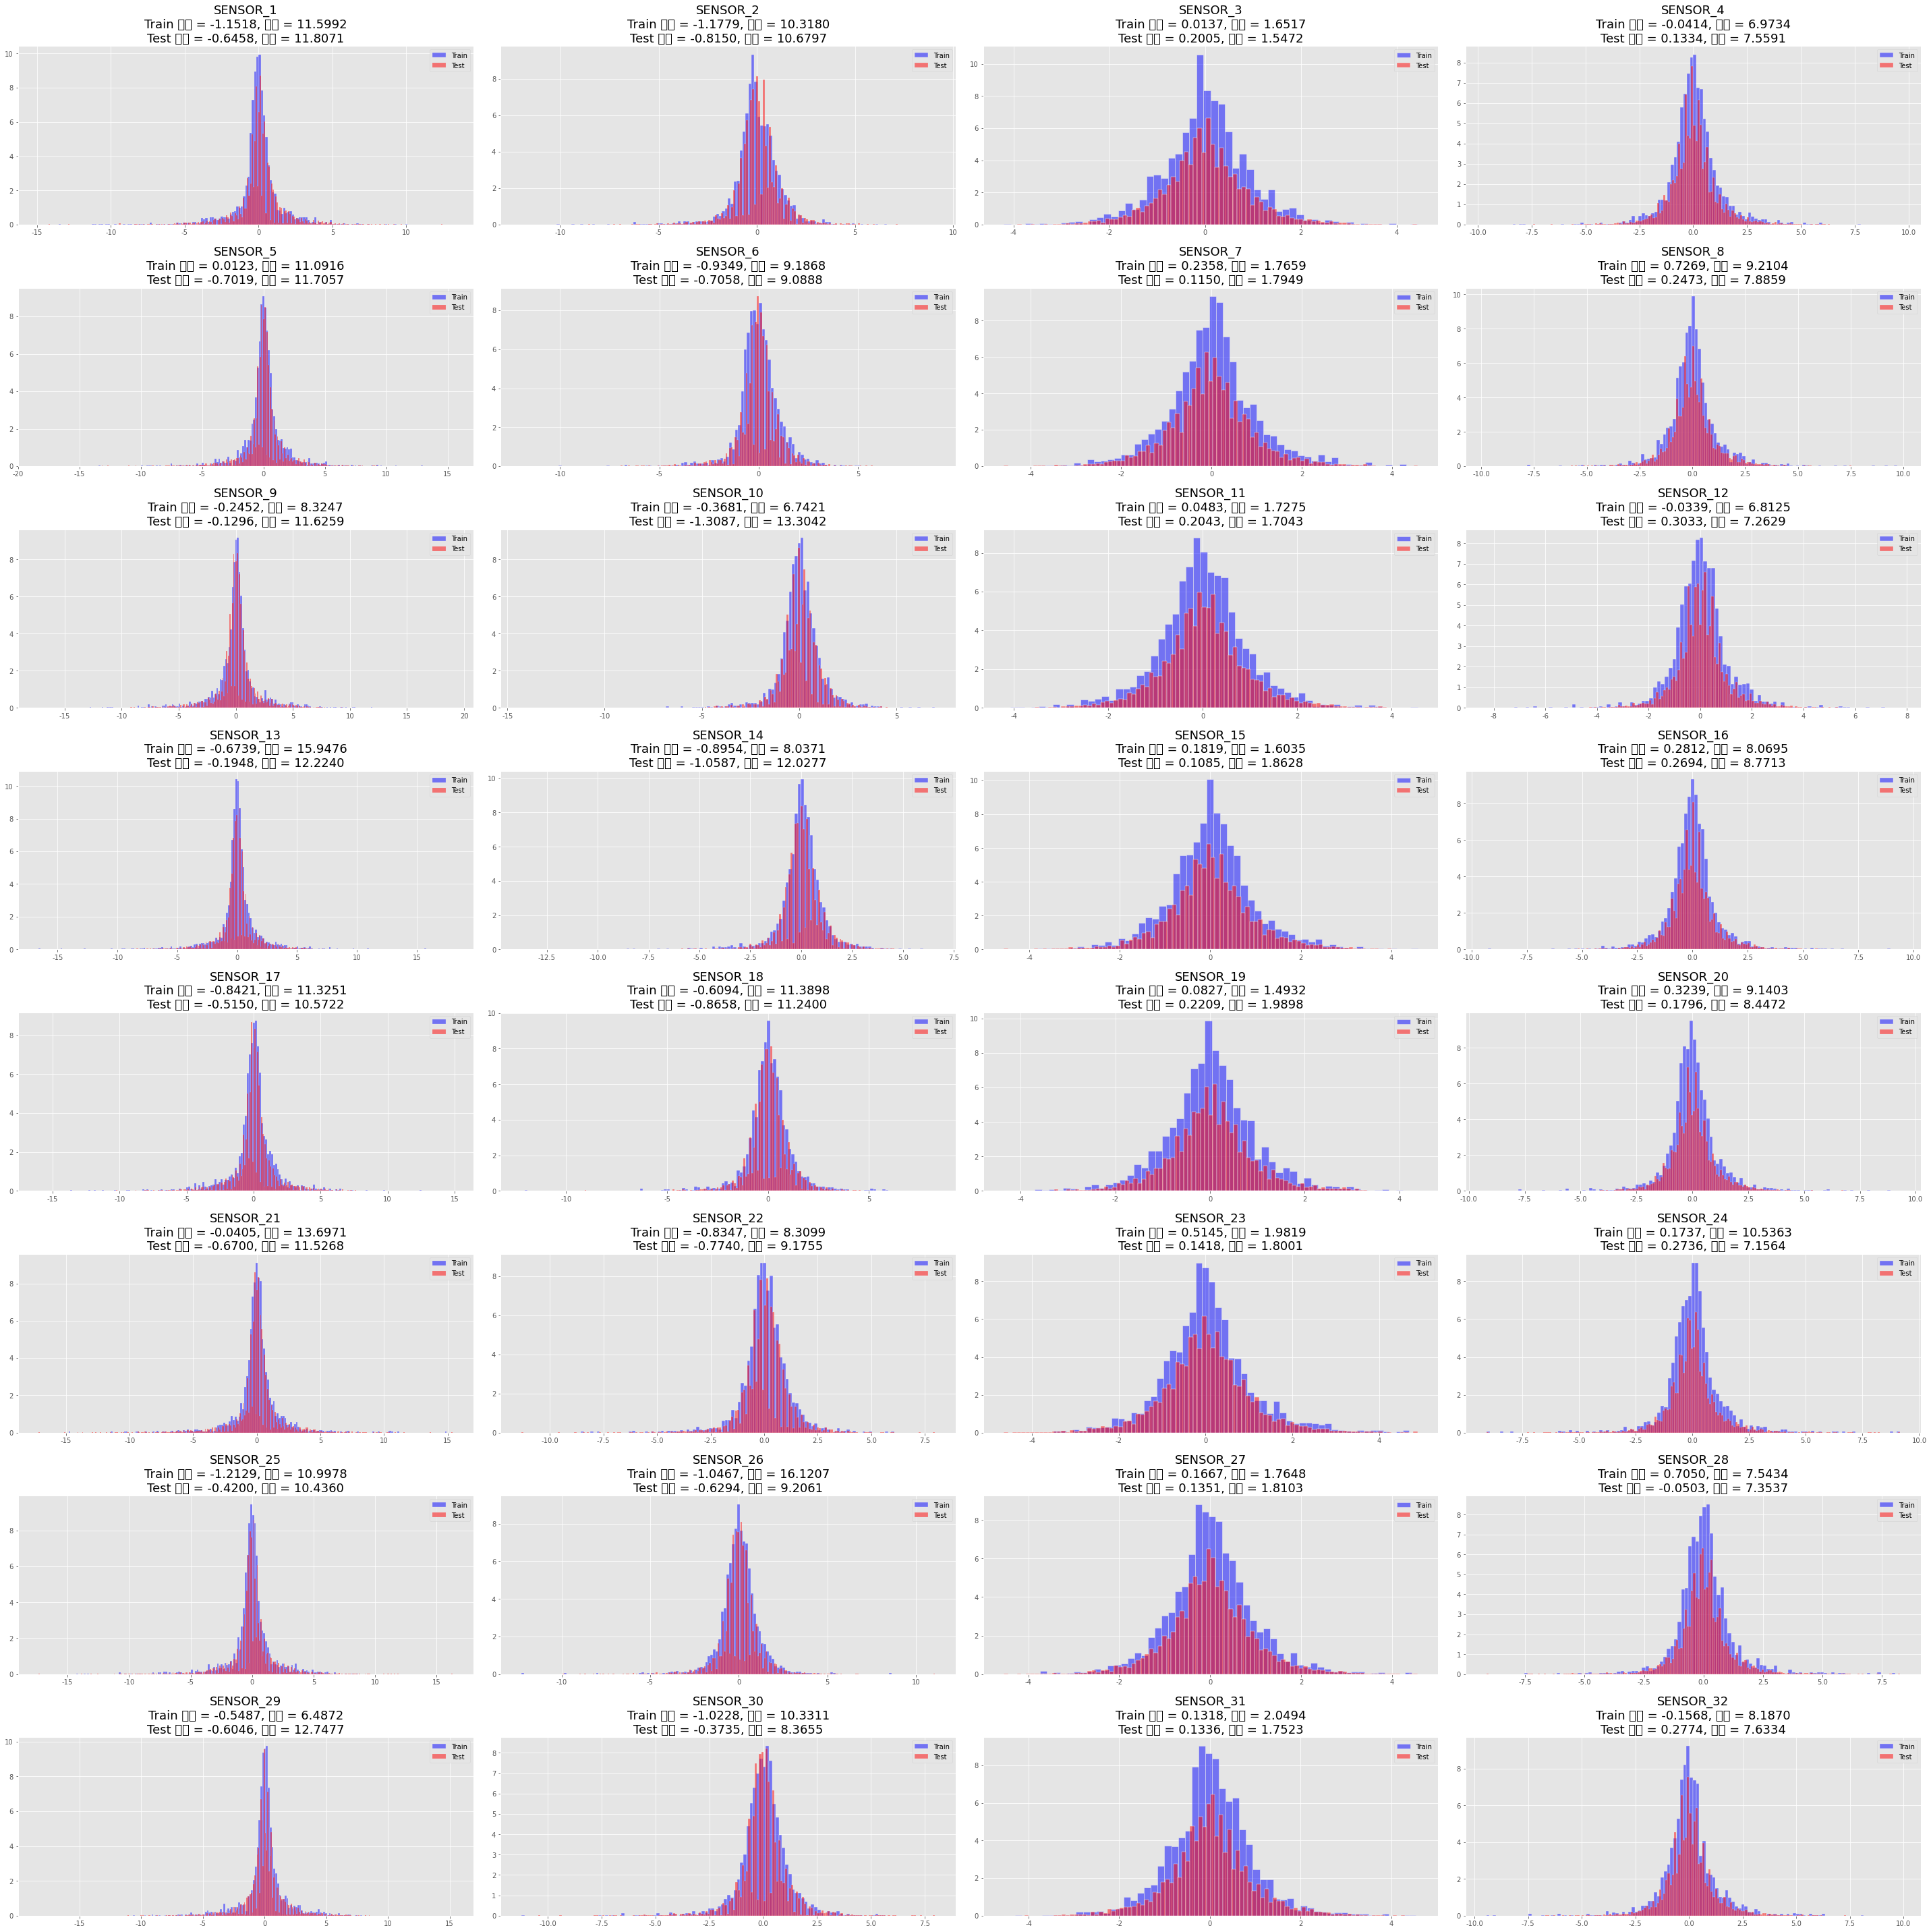

In [20]:
# RobustScaler() 함수를 사용하여 스케일링 진행
robust_train, robust_test = feature_scale_plot(scaler = RobustScaler(), train = train_df, test = test_df)

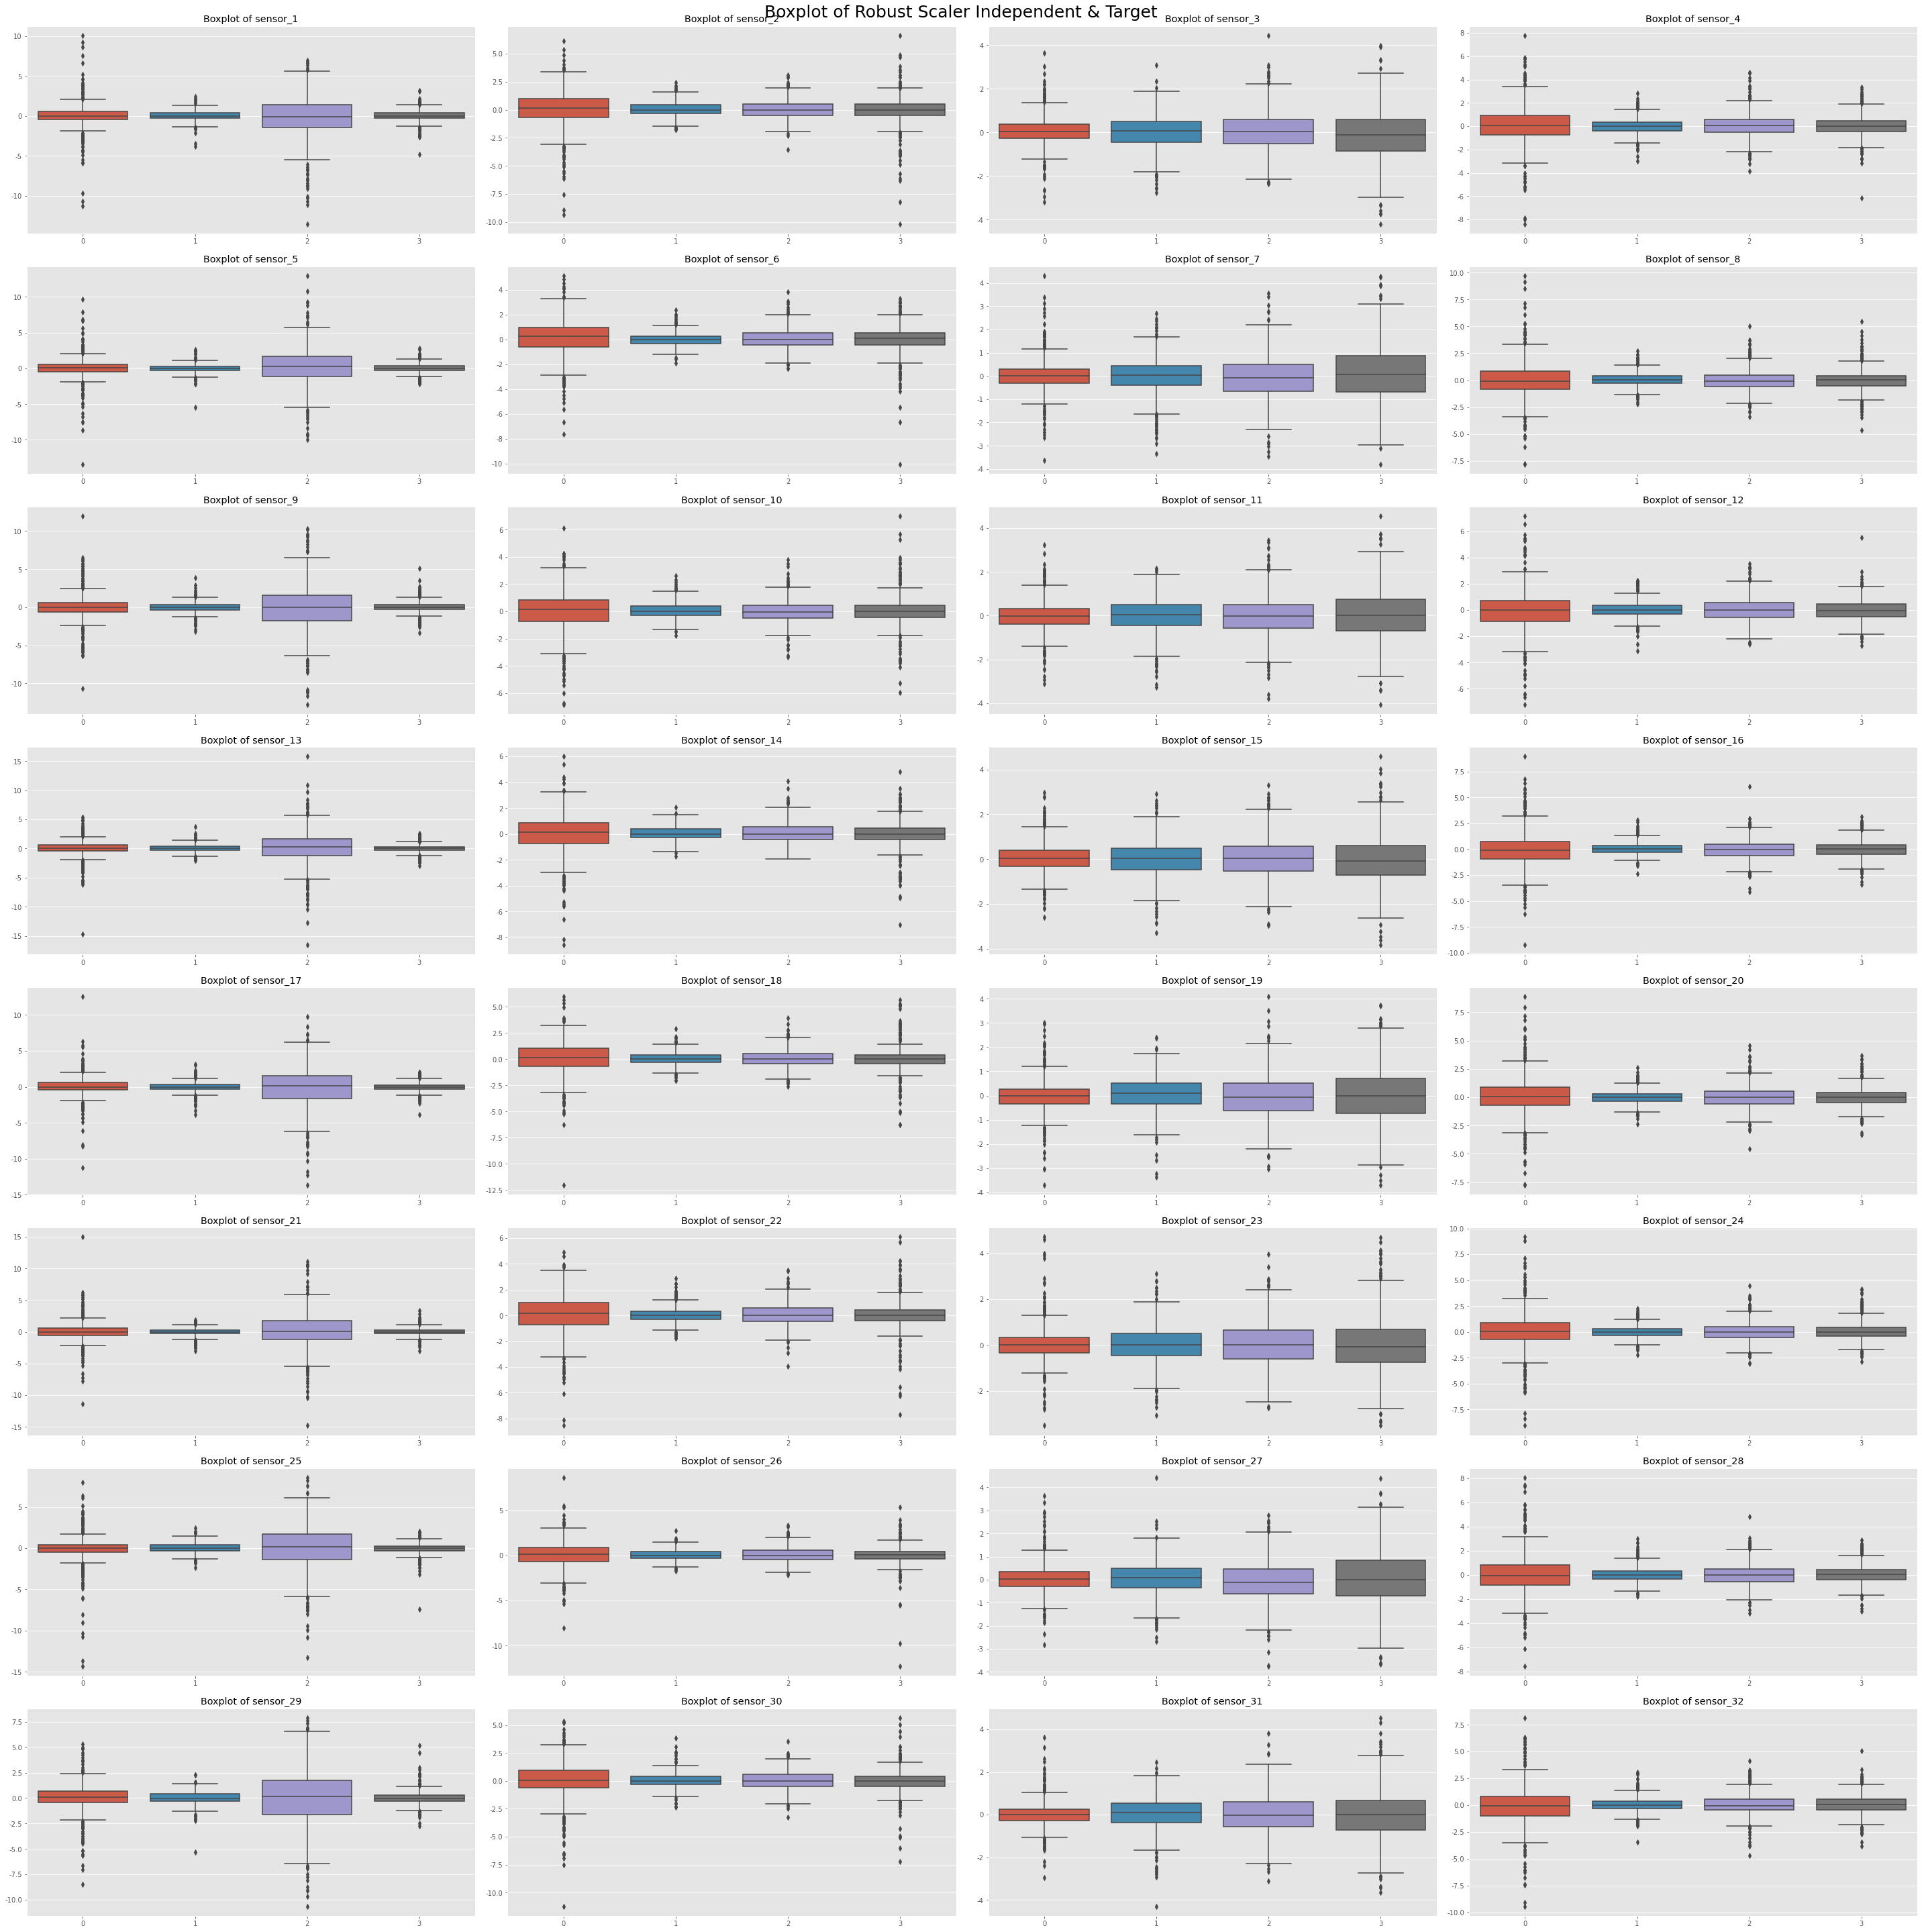

In [21]:
# Robust Scaler Independent VS Target
fig, axes = plt.subplots(nrows = 8, ncols = 4, figsize = (40, 40))

column_list = robust_train.drop(["id", "target"], axis=1).columns.tolist()

for index, column in enumerate(column_list):

  row = index // 4
  col = index %  4

  # Boxplot
  sns.boxplot(x="target", y=column, data=robust_train, ax=axes[row][col])

  axes[row][col].set_title("Boxplot of {}".format(column))
  axes[row][col].set_xlabel("")
  axes[row][col].set_ylabel("")

fig.suptitle(t="Boxplot of Robust Scaler Independent & Target", y=1, fontsize=25)
fig.tight_layout(pad=1.5)

- RobustScaler() 함수를 통해 표준화 작업을 진행해도 큰 변화가 없음을 확인할 수 있다.
- 또한, Boxplot에서도 앞의 두 가지 방법과 큰 차이가 없는 것으로 보인다.
- **세 가지 방법은 진행해본 결과, 스케일링 작업을 먼저 수행해주는 것 보다 이상치를 처리해 준 후 스케일링 작업을 수행해주는 것이 더 적절하다고 생각된다.**

<br>

### 2.4 Correlation Analysis

---
- 이제 각 변수들간에 어떤 관계가 있는지 상관분석을 진행해보도록 한다.

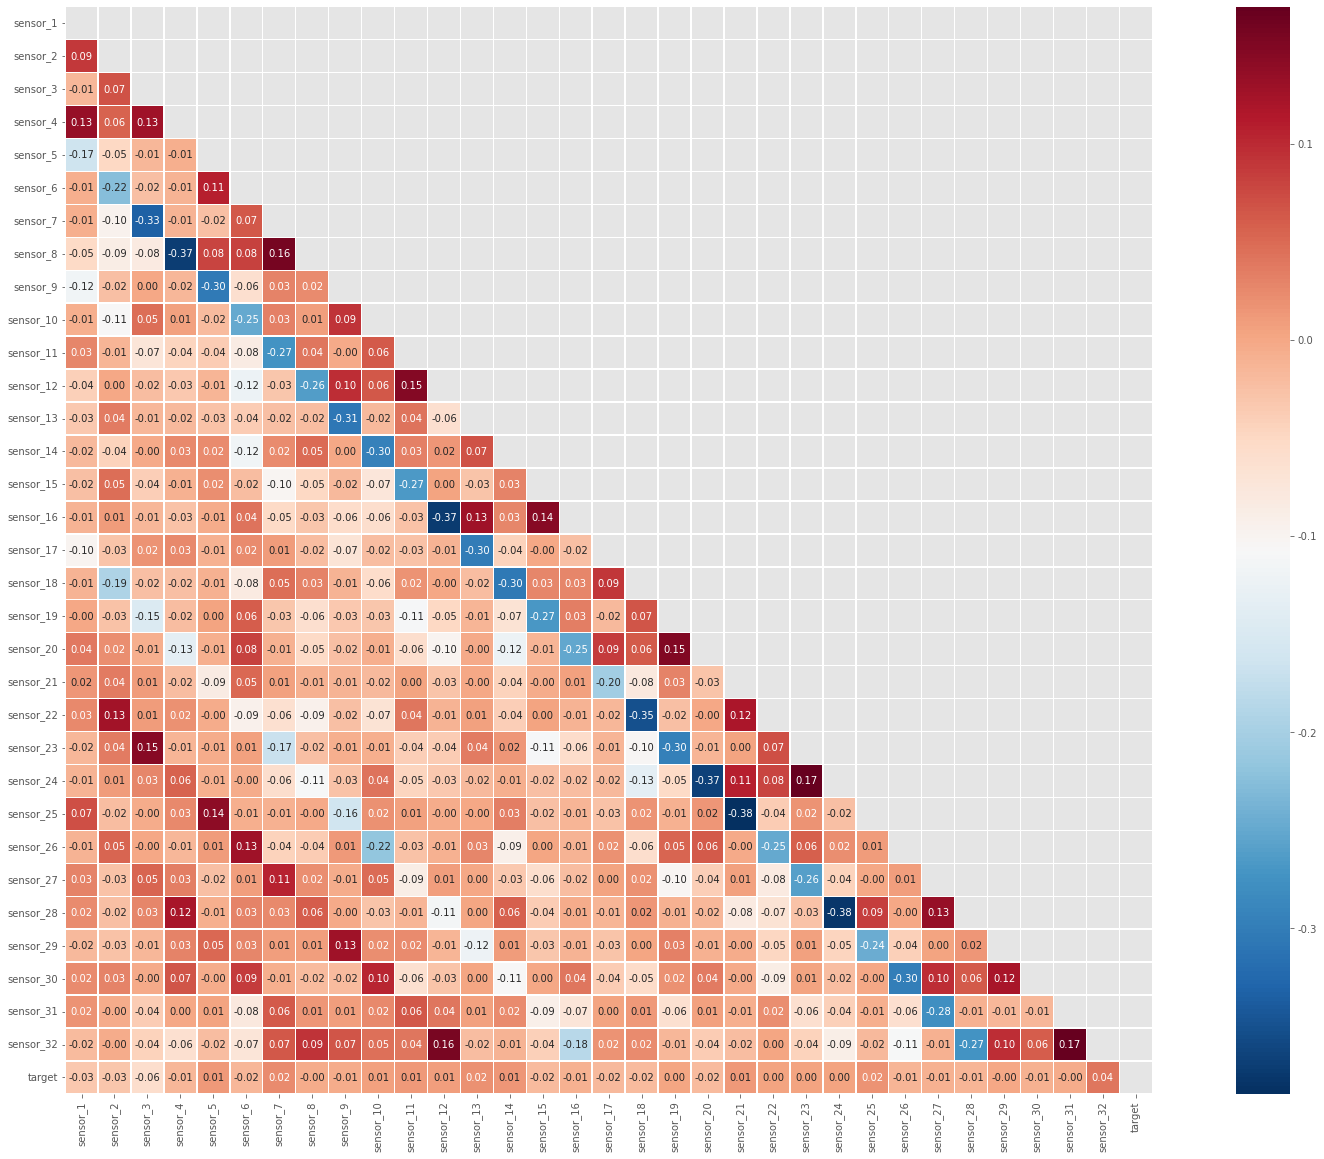

In [24]:
# 상관게수 데이터 생성
corr_data = train_df.drop(["id"], axis = 1).corr()

# 히트맵 옵션 설정
mask = np.zeros_like(corr_data, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(30,20))

sns.heatmap(corr_data, mask=mask, annot=True, fmt=".2f", linewidth=0.5, square=True, cmap="RdBu_r")
plt.show()

- 예측 변수를 정수형이라고 가정하였을 때, 예측 변수와 상관관계가 높은 독립 변수는 식별되지 않는다.
- 예측 변수와 관계가 있는 변수들은 찾을 수 없지만, 독립 변수들간의 약한 상관관계가 있는 변수들을 자세히 살펴보도록 하자.
- 약한 상관관계가 있는 변수들을 살펴보면 위의 Target별 Boxplot에서 서로 비슷한 분포를 나타냈던 변수들임을 확인할 수 있다.
- 예를 들어, **sensor_21**과 **sensor_25** 상관계수는 **-0.38**이며, 두 변수는 0과 2 클래스에서 이상치가 많이 식별되었다.

<br>

### 2.5 PCA(Principal Component Analysis)

---
- 앞의 Boxplot of Independent VS Target과 Correlation Analysis에서 서로 상관관계가 있고 비슷한 분포를 나타내는 변수들이 있음을 확인하였다.
- 앞의 분석내용을 바탕으로 주성분분석을 수행해보도록 하자.
- 현재 과정에서 주성분분석 방법은 모든 변수를 사용하는 것이 아니라, 아래와 같이 4개의 그룹으로 나눈 후 각 그룹마다 주성분 분성을 수행하도록 하자.
- **First Group** : sensor_1, sensor_5, sensor_9, sensor_13, sensor_17, sensor_21, sensor_25, sensor_29
- **Second Group** : sensor_2, sensor_6, sensor_10, sensor_14, sensor_18, sensor_22, sensor_26, sensor_30
- **Third Group** : sensor_3, sensor_7, sensor_11, sensor_15, sensor_19, sensor_23, sensor_27, sensor_31
- **Fourth Group** : sensor_4, sensor_8, sensor_12, sensor_16, sensor_20, sensor_24, sensor_28, sensor_32
- 주성분 분석을 수행하기 전에 Scaling 과정이 필요하며, 위에서 사용했던 standard_train 데이터를 사용한다.

In [25]:
# 주성분분석 수행 함수 생성
def PCA_plot(data = None, column_list = None):
    
    # 데이터 보존을 위해 데이터 복사
    function_data = data.copy()
    
    # 주성분분석에 사용할 변수만 추출
    pca_data = function_data[column_list]
    
    # PCA 객체 생성 후 학습
    pca = PCA(n_components = len(column_list), random_state = 1025)
    pca.fit(pca_data)
    
    # PCA 결과 시각화
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))
    
    # Scree Plot
    axes[0].plot(pca.explained_variance_, marker = "o", color = "blue", alpha = 0.5, linewidth = 3)
    axes[0].set_title("PCA Scree Plot", fontsize = 13)
    
    # Explained Variance Ratio Plot
    plot_data = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_), columns = ["Ratio"], index = ["주성분 {}".format(index + 1) for index in range(len(pca.explained_variance_ratio_))])
    
    sns.barplot(x = plot_data.index, y = "Ratio", data = plot_data, ax = axes[1])
    axes[1].set_title("Explained Variance Ratio Plot", fontsize = 13)
    axes[1].set_ylabel("")
    
    for rect in axes[1].patches:
        axes[1].text(rect.get_x() + rect.get_width() / 2, rect.get_height(), np.round(rect.get_height() * 100, 2), ha = "center", fontsize = 12)
    
    fig.tight_layout()

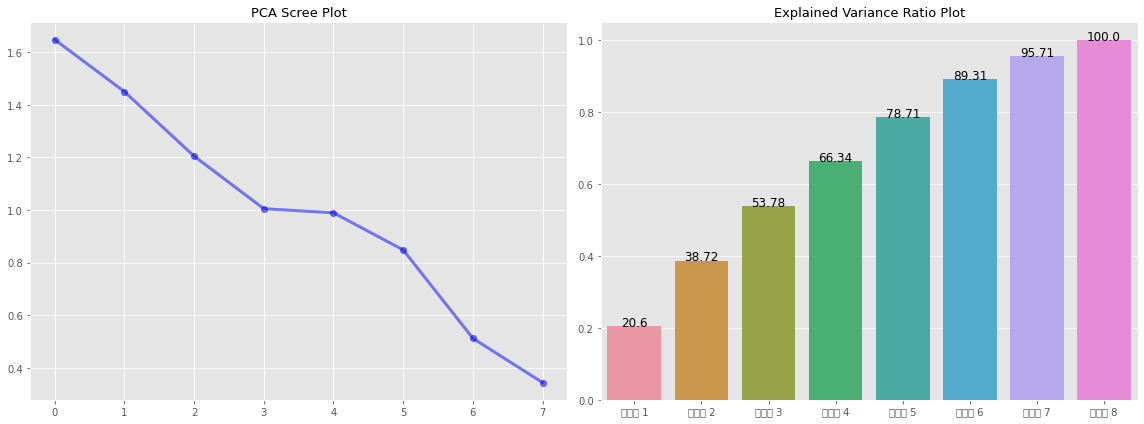

In [26]:
# First Group
PCA_plot(data = standard_train, column_list = ["sensor_1", "sensor_5", "sensor_9", "sensor_13", "sensor_17", "sensor_21", "sensor_25", "sensor_29"])

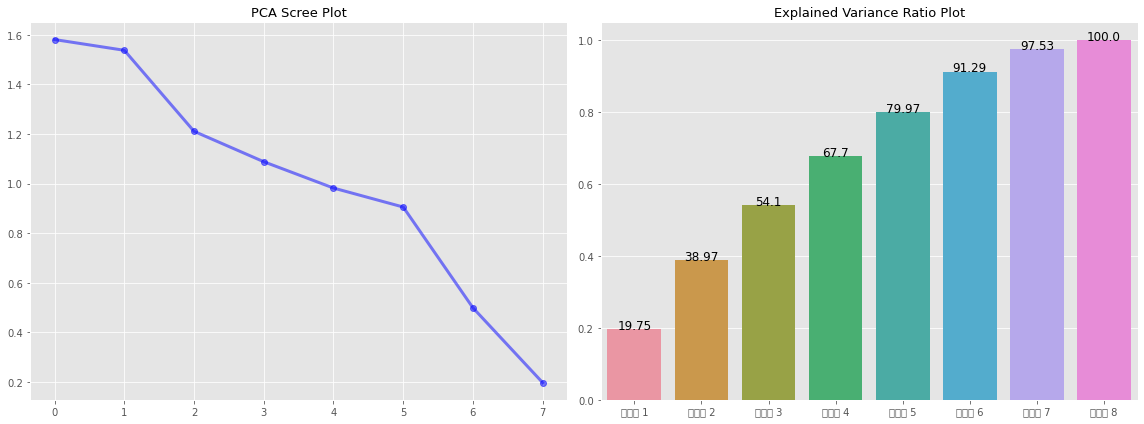

In [27]:
# Second Group
PCA_plot(data = standard_train, column_list = ["sensor_2", "sensor_6", "sensor_10", "sensor_14", "sensor_18", "sensor_22", "sensor_26", "sensor_30"])

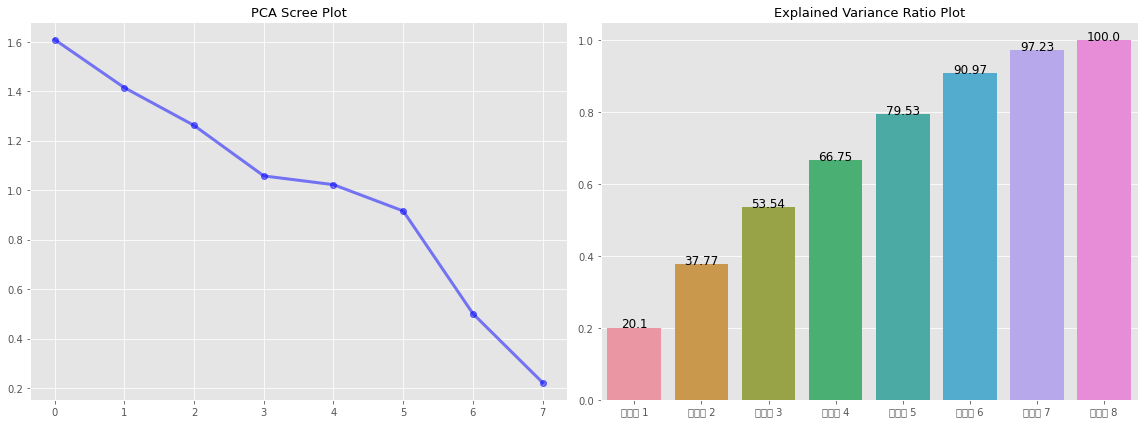

In [28]:
# Third Group
PCA_plot(data = standard_train, column_list = ["sensor_3", "sensor_7", "sensor_11", "sensor_15", "sensor_19", "sensor_23", "sensor_27", "sensor_31"])

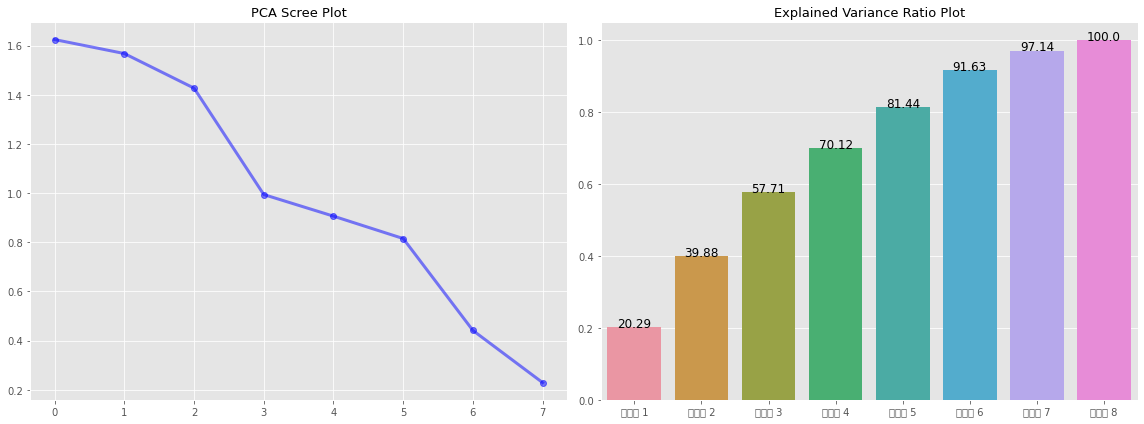

In [29]:
# Fourth Group
PCA_plot(data = standard_train, column_list = ["sensor_4", "sensor_8", "sensor_12", "sensor_16", "sensor_20", "sensor_24", "sensor_28", "sensor_32"])

- 주성분 분석을 통해 차원을 축소시켜줄 수 있을것이라고 생각했지만, 위의 결과를 통해 축소시킬 수 없음을 확인할 수 있다.
- 4개의 그룹 Scree plot에서 **Elbow Point**를 찾을 수 없다.
- 또한, Explainde Variance Ratio Plot**에서 대부분 6번째 주성분 축까지 사용해야 원본 데이터 분산의 90%를 설명할 수 있음을 볼 수 있다.
- 따라서 현재 데이터에서 주성분 분석을 통해 차원을 축소시켜주는 방법은 적절하지 못한 방법으로 판단된다.